In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

In [5]:
animes = pd.read_csv('anime_filtered.csv')
users = pd.read_csv('users_filtered.csv')
animelists = pd.read_csv('animelists_filtered.csv')

In [92]:
#plt.rcParams.update(mpl.rcParamsDefault)  # for recovering from xkcd

# taken from https://github.com/ctokheim/matplotlibrc
plt.style.use('seaborn')
plt.xkcd()

conf = {
    'font.size': 14.0,
    'figure.titlesize': 'x-large',
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
#    'xtick.labelsize': 'medium',
#    'ytick.labelsize': 'medium',
#    'legend.fontsize': 'medium',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.fontsize': 'large',
}

plt.rcParams.update(conf)


In [7]:
users.describe()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,access_rank,stats_mean_score,stats_rewatched,stats_episodes
count,1.161330e+05,116133.000000,116133.000000,116133.000000,116133.000000,116133.000000,1.161330e+05,0.0,116133.000000,116133.000000,1.161330e+05
mean,1.810832e+06,14.610283,195.498807,11.338018,11.818518,74.936332,9.329691e+01,NaN,7.713389,13.991079,6.611762e+03
std,1.996139e+06,32.459424,256.533148,31.622640,31.117077,177.889249,7.636053e+03,NaN,1.538595,54.731186,7.155270e+05
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.000000,0.000000e+00
25%,1.990980e+05,3.000000,47.000000,0.000000,0.000000,5.000000,2.246000e+01,NaN,7.310000,0.000000,1.349000e+03
50%,5.615770e+05,7.000000,121.000000,4.000000,3.000000,27.000000,4.990000e+01,NaN,7.880000,1.000000,3.017000e+03
75%,3.464591e+06,16.000000,253.000000,12.000000,12.000000,80.000000,9.277000e+01,NaN,8.460000,10.000000,5.642000e+03
max,7.251737e+06,2934.000000,11536.000000,2562.000000,2457.000000,12051.000000,2.601351e+06,NaN,10.000000,9404.000000,2.437949e+08


In [8]:
# dropping users with invalid and obviously incorrect dates
users['birth_date'] = pd.to_datetime(users['birth_date'], errors='coerce')
users['last_online'] = pd.to_datetime(users['last_online'], errors='coerce')
users['join_date'] = pd.to_datetime(users['join_date'], errors='coerce')
users = users.dropna(subset=['birth_date', 'last_online', 'join_date'])
#users = users[users['last_online'].dt.year > 1950]

In [9]:
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'], unit='s')

In [10]:
users.describe()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,access_rank,stats_mean_score,stats_rewatched,stats_episodes
count,1.161310e+05,116131.000000,116131.00000,116131.000000,116131.000000,116131.000000,1.161310e+05,0.0,116131.000000,116131.000000,1.161310e+05
mean,1.810839e+06,14.610259,195.49259,11.338084,11.818429,74.935771,9.329698e+01,NaN,7.713378,13.991286,6.611773e+03
std,1.996147e+06,32.459676,256.52762,31.622901,31.117304,177.890713,7.636119e+03,NaN,1.538603,54.731634,7.155332e+05
min,1.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,NaN,0.000000,0.000000,0.000000e+00
25%,1.991000e+05,3.000000,47.00000,0.000000,0.000000,5.000000,2.246000e+01,NaN,7.310000,0.000000,1.349000e+03
50%,5.615770e+05,7.000000,121.00000,4.000000,3.000000,27.000000,4.990000e+01,NaN,7.880000,1.000000,3.017000e+03
75%,3.464671e+06,16.000000,253.00000,12.000000,12.000000,80.000000,9.277000e+01,NaN,8.460000,10.000000,5.642000e+03
max,7.251737e+06,2934.000000,11536.00000,2562.000000,2457.000000,12051.000000,2.601351e+06,NaN,10.000000,9404.000000,2.437949e+08


In [11]:
users.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0
4,terune_uzumaki,327311,5,5,0,0,0,15.20,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,920.0


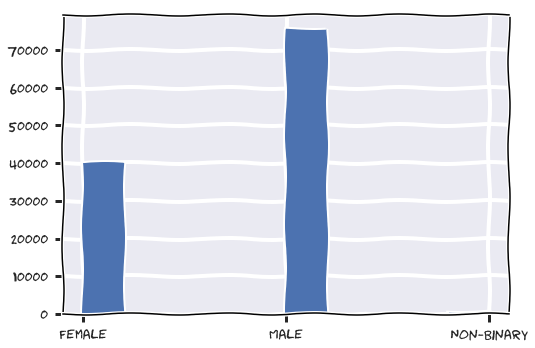

In [12]:
users['gender'].hist()

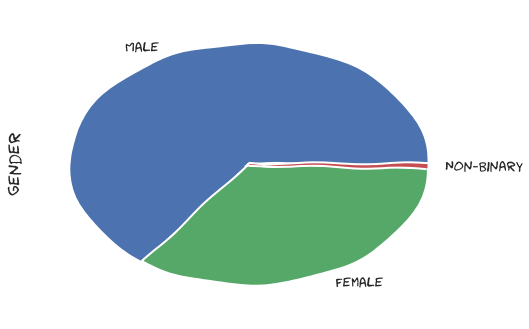

In [13]:
users['gender'].value_counts().plot.pie()

In [14]:
users.dtypes

username                            object
user_id                              int64
user_watching                        int64
user_completed                       int64
user_onhold                          int64
user_dropped                         int64
user_plantowatch                     int64
user_days_spent_watching           float64
gender                              object
location                            object
birth_date                  datetime64[ns]
access_rank                        float64
join_date                   datetime64[ns]
last_online                 datetime64[ns]
stats_mean_score                   float64
stats_rewatched                    float64
stats_episodes                     float64
dtype: object

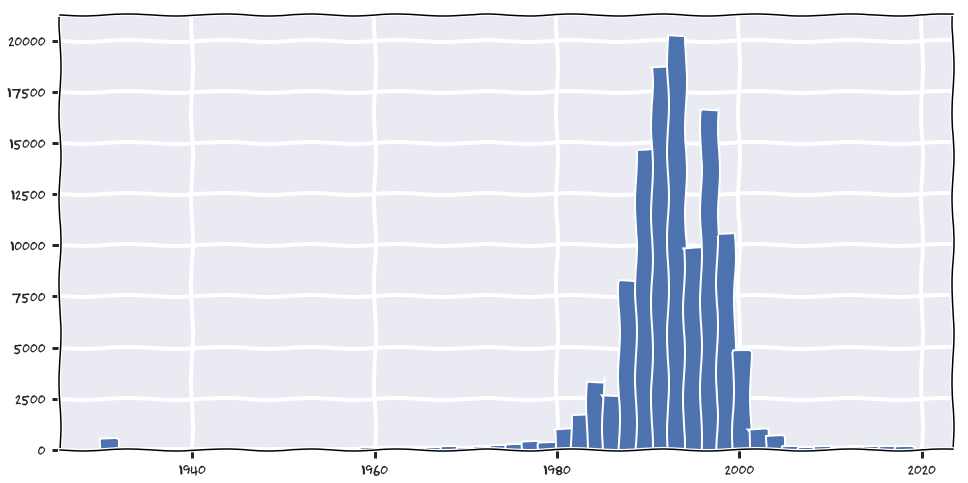

In [15]:
users['birth_date'].dt.year.hist(bins=50, figsize=(16, 8))

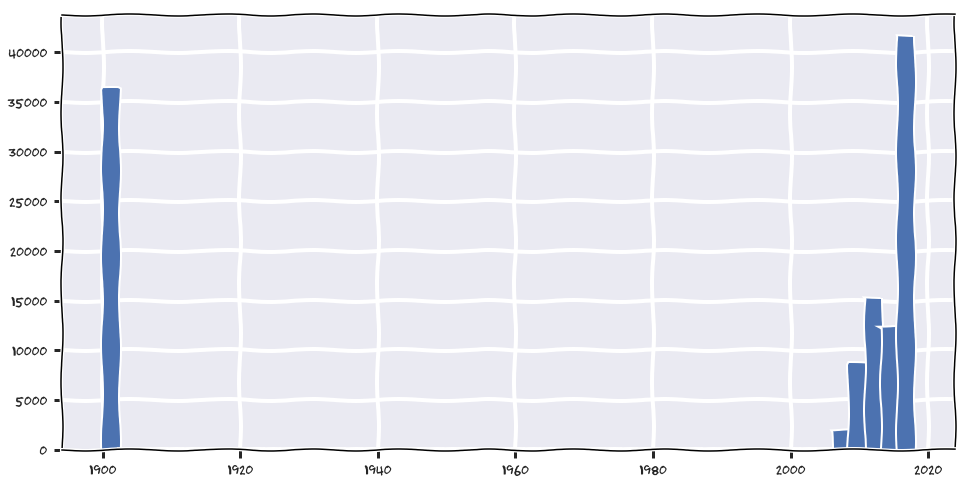

In [16]:
users['last_online'].dt.year.hist(bins=50, figsize=(16, 8))

In [17]:
users['birth_date'].value_counts()

1993-01-01    365
1991-01-01    362
1990-01-01    352
1992-01-01    352
1994-01-01    335
1995-01-01    307
1989-01-01    307
1996-01-01    242
1988-01-01    209
1997-01-01    204
1987-01-01    173
1998-01-01    133
1986-01-01    130
1985-01-01    107
1999-01-01     98
1930-01-01     81
1983-01-01     79
1984-01-01     78
1993-09-01     53
1994-09-01     51
1994-03-01     48
1996-10-10     47
1994-06-01     47
1991-11-01     47
1995-09-01     46
1993-05-05     45
1993-03-01     45
1995-11-01     44
1994-05-20     43
1993-09-10     43
             ... 
1977-12-05      1
1980-03-18      1
1977-06-26      1
1972-10-09      1
2013-11-15      1
2013-10-18      1
1980-11-15      1
1980-04-13      1
1973-06-07      1
1930-01-18      1
1971-03-22      1
1978-01-26      1
1981-12-24      1
1979-09-12      1
1963-09-18      1
1961-06-06      1
1982-01-18      1
1982-06-12      1
1983-09-29      1
2013-06-05      1
2017-12-29      1
1974-01-08      1
1976-04-21      1
1932-05-02      1
1930-01-19

In [18]:
users[users['birth_date'] == '1944-11-19']

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
27130,LulyPie,231964,88,219,1,7,181,138.56,Female,SinSendGoodMe,1944-11-19,NaN,2009-09-09,1900-01-13 01:01:00,7.54,23.0,8319.0


In [19]:
users['last_online'].value_counts()

1900-05-13 14:11:00    7
1900-05-13 16:19:00    7
2013-09-13 08:34:00    6
1900-05-11 11:43:00    6
2018-05-15 12:58:00    6
2013-09-13 08:29:00    6
2018-05-14 12:44:00    6
1900-05-12 10:21:00    5
1900-05-12 13:21:00    5
1900-05-13 12:04:00    5
1900-01-18 13:37:00    5
2013-09-13 13:00:00    5
1900-05-09 15:48:00    5
1900-05-14 12:06:00    5
1900-05-14 08:57:00    5
1900-05-12 20:22:00    5
1900-05-14 08:24:00    5
1900-05-11 12:52:00    5
1900-05-13 09:19:00    5
1900-05-13 17:14:00    5
1900-05-13 14:01:00    5
1900-05-13 13:55:00    5
2013-09-13 08:16:00    5
1900-05-11 16:30:00    5
1900-05-16 19:55:00    5
1900-05-12 17:29:00    5
1900-05-12 12:10:00    5
1900-05-13 12:55:00    5
2018-05-16 12:58:00    5
1900-05-13 13:31:00    5
                      ..
2013-10-26 16:28:00    1
1900-02-28 10:36:00    1
1900-01-20 23:01:00    1
1900-03-27 17:26:00    1
2016-04-20 17:02:00    1
2017-01-14 18:32:00    1
2016-11-02 21:23:00    1
2009-11-17 23:43:00    1
2015-08-11 07:31:00    1


In [20]:
users[users['last_online'].dt.year == 1900].head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
5,Bas_G,5015094,35,114,6,20,175,30.81,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,1900-05-10 13:53:00,7.86,0.0,1847.0
6,HimeAria,3129315,2,87,2,0,28,20.12,Female,Poland,1996-09-26,NaN,2013-09-08,1900-04-27 10:52:00,8.23,0.0,1314.0
8,Slimak,61677,79,224,0,3,84,126.17,Male,Poland,1988-02-21,NaN,2008-05-18,1900-05-01 05:04:00,7.77,2.0,7472.0


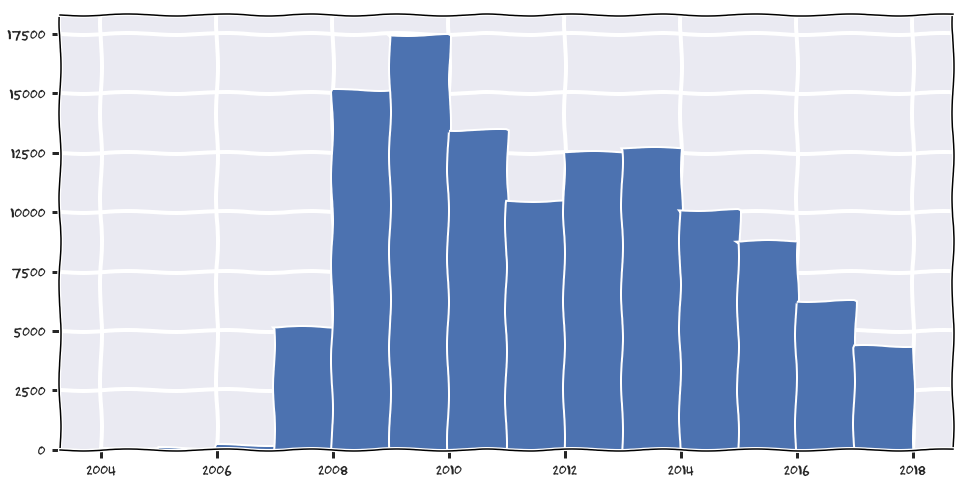

In [21]:
users['join_date'].dt.year.hist(bins=14, figsize=(16, 8))

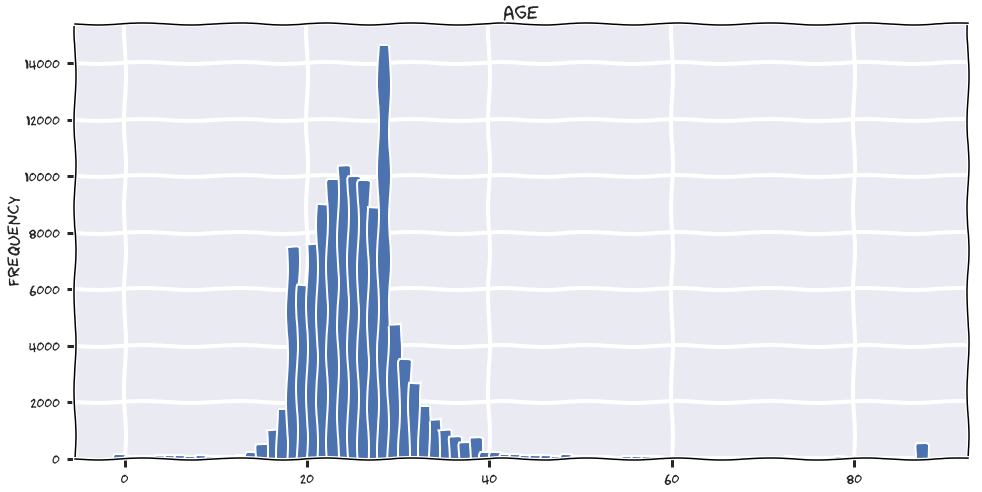

In [22]:
(2018 - users['birth_date'].dt.year).plot(kind='hist', bins=80, figsize=(16, 8), title='age')
plt.gca().grid('on')

In [23]:
# some user with weird last online date
animelists[animelists['username'] == 'RedvelvetDaisuki']

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,2012-12-14 10:25:01,NaN
95629,RedvelvetDaisuki,120,1,2013-02-02,0000-00-00,3,3,NaN,0,2013-02-02 12:27:53,NaN
212785,RedvelvetDaisuki,269,282,2012-11-00,0000-00-00,6,3,NaN,0,2012-12-30 10:18:22,NaN
276646,RedvelvetDaisuki,721,38,2014-07-27,2014-00-00,8,2,0.0,0,2018-02-09 15:02:20,NaN
288406,RedvelvetDaisuki,853,26,2012-12-24,2012-12-24,9,2,NaN,0,2012-12-24 13:33:51,NaN
387077,RedvelvetDaisuki,1571,0,0000-00-00,0000-00-00,0,6,0.0,0,2013-03-19 03:21:02,NaN
419888,RedvelvetDaisuki,1698,23,2013-03-21,2013-03-22,8,2,NaN,0,2013-03-22 15:38:38,NaN
446319,RedvelvetDaisuki,1735,312,2012-00-00,0000-00-00,9,3,NaN,0,2013-06-05 03:49:42,NaN
566786,RedvelvetDaisuki,3092,12,2012-12-29,2012-12-30,10,2,NaN,0,2013-04-07 15:33:35,"Slice of Life, Comedy, Romance, Yaoi"
604812,RedvelvetDaisuki,4224,25,2014-08-10,2014-08-13,7,2,NaN,0,2014-08-13 03:30:48,NaN


In [24]:
animelists.dtypes

username                       object
anime_id                        int64
my_watched_episodes             int64
my_start_date                  object
my_finish_date                 object
my_score                        int64
my_status                       int64
my_rewatching                 float64
my_rewatching_ep                int64
my_last_updated        datetime64[ns]
my_tags                        object
dtype: object

In [25]:
grouped_lists = animelists.groupby('username')

In [26]:
%%timeit
# some users have weird last online date, but have correct last update in their animelist, so I can infer it from that.
#Now I am just trying it
#animelists[animelists['username'] == 'RedvelvetDaisuki']['my_last_updated'].max()
# 3.2 s ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
grouped_lists.get_group('RedvelvetDaisuki')['my_last_updated'].max()
# 991 µs ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
# so once grouping and then queying group per username is much faster than performing search each time

759 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
#now really inferring the best estimation of last online
users.loc[users['last_online'].dt.year == 1900, 'last_online'] = users[users['last_online'].dt.year == 1900]['username'].apply(lambda x: grouped_lists.get_group(x)['my_last_updated'].max())


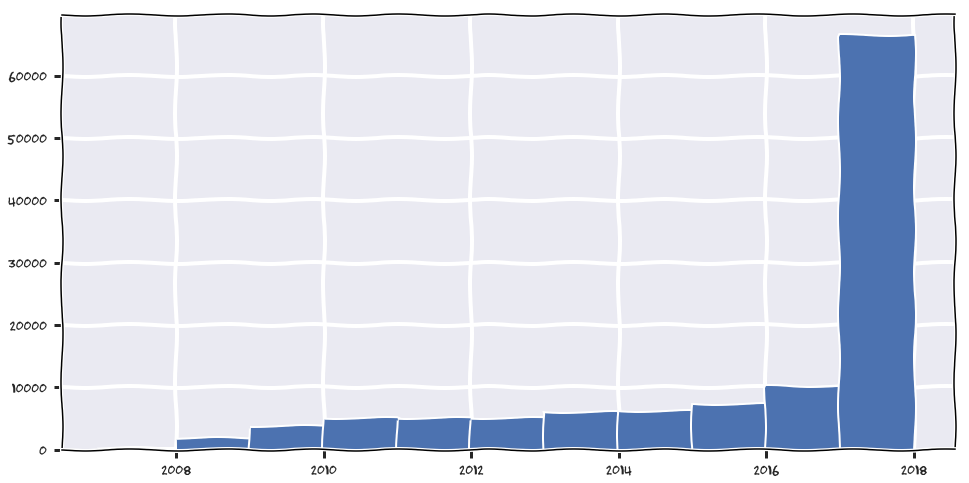

In [28]:
users['last_online'].dt.year.hist(bins=11, figsize=(16, 8))

In [29]:
animes.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."


In [30]:
animes['episodes'].value_counts()

1       6855
2       1187
12      1034
13       637
3        558
26       542
0        503
4        373
6        303
24       214
52       199
25       176
10       152
5        144
51       111
50        92
7         86
11        86
39        85
8         66
9         48
22        47
20        46
23        37
16        34
48        34
14        33
49        33
47        29
15        27
        ... 
726        1
1006       1
220        1
172        1
132        1
124        1
122        1
154        1
162        1
258        1
330        1
1274       1
1306       1
1818       1
67         1
83         1
131        1
147        1
155        1
203        1
283        1
291        1
331        1
475        1
1787       1
87         1
431        1
79         1
92         1
1471       1
Name: episodes, Length: 196, dtype: int64

In [31]:
animes[animes['anime_id'] == 21]

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
34,21,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,...,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."


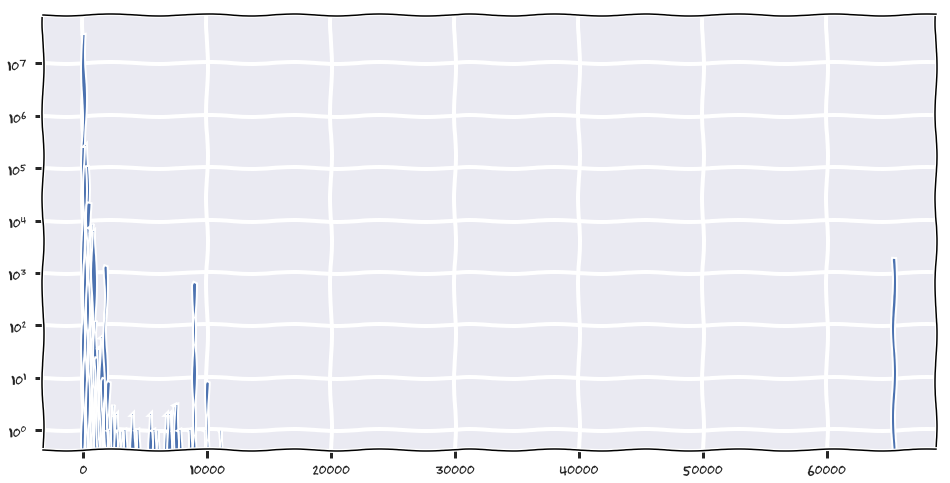

In [32]:
animelists['my_watched_episodes'].hist(bins=500, figsize=(16, 8))
plt.gca().set_yscale('log')


In [33]:
print('unique anime before:', animelists['anime_id'].unique().shape)
print('animelists before:', animelists.shape)
# some users have insanely large amount of episodes, list and ban them
users_for_ban = animelists[animelists['my_watched_episodes'] == 65535]['username'].unique()
# banning users with 65535 episodes of single anime in their list -> not trustworthy
print(users_for_ban)
print('num of users for ban:', len(users_for_ban))
print('num of records with 65535 episodes filled:', (animelists['my_watched_episodes'] == 65535).sum())



unique anime before: (14474,)
animelists before: (35802006, 11)
['Gothicbabe26' 'LeoAnimeMan' 'narutofan69' 'Angel_D' 'dheiin_society'
 'heizwei' 'warrose' 'Takehara_Minami' 'ozieboy' 'YoruNoMajo' 'Xiet'
 'Kihara-Kun' 'donakos' 'Amaru-kun' 'Archeologist' 'konan_akatsuki_'
 'MoiZzZ' 'TheDerpyMuffin' 'ajkla' 'zaturama007' 'thomasrm' 'The-Marker'
 'Taizai' 'Koska-chan' 'asswithnolife']
num of users for ban: 25
num of records with 65535 episodes filled: 1863


In [34]:
users = users[~users['username'].isin(users_for_ban)]
animelists = animelists[~animelists['username'].isin(users_for_ban)]
animelists = animelists.reset_index(drop=True)  # so indices are aligned, otherwise it breaks when using same mask with other dataframe
print('unique anime after:', animelists['anime_id'].unique().shape)
print('animelists after:', animelists.shape)

unique anime after: (14474,)
animelists after: (35793977, 11)


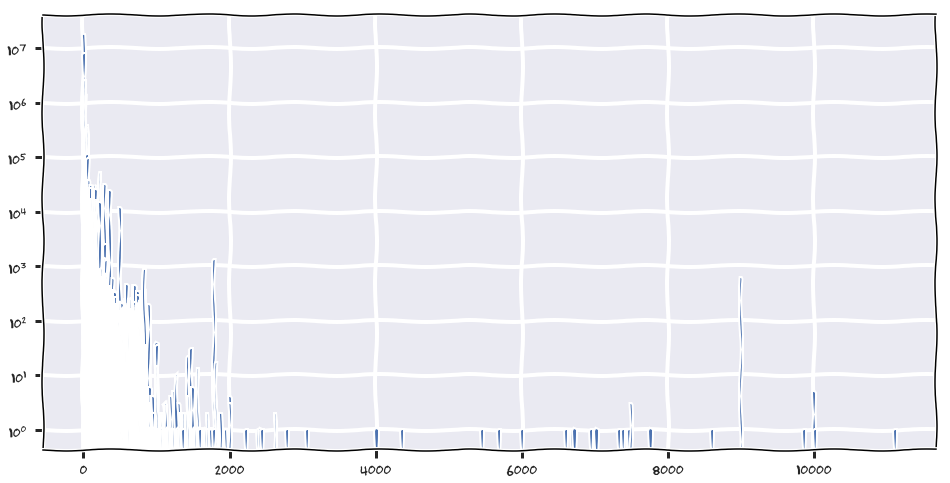

In [35]:
animelists['my_watched_episodes'].hist(bins=5000, figsize=(16, 8))
plt.gca().set_yscale('log')


In [36]:
animelists_with_eps = pd.merge(animelists, animes[['anime_id', 'episodes', 'title']], on='anime_id')

In [37]:
display(animelists_with_eps.shape)
display(animelists.shape)

(35793977, 13)

(35793977, 11)

In [38]:
animelists_with_eps.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,episodes,title
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN,0,One Piece
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,2012-12-14 10:25:01,NaN,0,One Piece
2,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,2009-09-30 07:39:05,NaN,0,One Piece
3,bskai,21,75,0000-00-00,0000-00-00,8,1,0.0,0,2010-06-15 21:31:23,NaN,0,One Piece
4,Slimak,21,834,0000-00-00,0000-00-00,10,1,0.0,0,2018-05-01 12:05:21,NaN,0,One Piece


In [39]:
# just showing shitheads with incorrectly filled episodes
err_mask = (animelists_with_eps['my_watched_episodes'] > animelists_with_eps['episodes']) & (animelists_with_eps['episodes'] != 0)
print('num of incorrect records: ', err_mask.sum())
print('num of users with incorrect records: ', len(animelists_with_eps[err_mask]['username'].unique()))
animelists_with_eps[err_mask]

num of incorrect records:  97931
num of users with incorrect records:  45905


,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,episodes,title
50353,heeroYuy,59,43,0000-00-00,0000-00-00,9,6,0.0,0,1970-01-01 00:00:00,NaN,26,Chobits
62647,Sieg83,59,27,0000-00-00,0000-00-00,10,2,0.0,0,2008-04-29 01:41:44,NaN,26,Chobits
65431,ultimaweaponx,59,27,0000-00-00,0000-00-00,8,2,0.0,0,1970-01-01 00:00:00,NaN,26,Chobits
67599,Yashima,59,9001,0000-00-00,0000-00-00,7,2,NaN,0,2014-09-02 14:32:43,NaN,26,Chobits
74194,naturefull,59,28,0000-00-00,0000-00-00,8,2,0.0,0,2009-08-12 21:05:02,NaN,26,Chobits
75238,Sakyosa,59,27,0000-00-00,0000-00-00,0,2,0.0,0,2008-12-01 21:18:25,NaN,26,Chobits
76289,NC7E,59,126,0000-00-00,0000-00-00,6,4,0.0,0,2013-01-21 22:28:27,NaN,26,Chobits
84822,Niero17,59,27,0000-00-00,0000-00-00,9,2,0.0,0,2008-04-25 10:59:30,NaN,26,Chobits
100680,MurTi,120,9001,2014-00-00,2014-00-00,6,2,0.0,0,2014-08-31 17:07:54,NaN,26,Fruits Basket
112321,Yashima,120,9001,0000-00-00,0000-00-00,10,2,NaN,0,2014-09-02 14:34:44,NaN,26,Fruits Basket


In [40]:
display(animelists_with_eps.dtypes)
display(animelists.dtypes)
display(animelists_with_eps.shape)
display(animelists.shape)
display(animelists_with_eps.index)
display(animelists.index)
display(animelists_with_eps[err_mask].shape)
display(animelists[err_mask].shape)

username                       object
anime_id                        int64
my_watched_episodes             int64
my_start_date                  object
my_finish_date                 object
my_score                        int64
my_status                       int64
my_rewatching                 float64
my_rewatching_ep                int64
my_last_updated        datetime64[ns]
my_tags                        object
episodes                        int64
title                          object
dtype: object

username                       object
anime_id                        int64
my_watched_episodes             int64
my_start_date                  object
my_finish_date                 object
my_score                        int64
my_status                       int64
my_rewatching                 float64
my_rewatching_ep                int64
my_last_updated        datetime64[ns]
my_tags                        object
dtype: object

(35793977, 13)

(35793977, 11)

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,        7,        8,        9,
            ...
            35793967, 35793968, 35793969, 35793970, 35793971, 35793972,
            35793973, 35793974, 35793975, 35793976],
           dtype='int64', length=35793977)

RangeIndex(start=0, stop=35793977, step=1)

(97931, 13)

(97931, 11)

In [41]:
display(err_mask.size)
animelists.size

35793977

393733747

In [42]:
# fixing incorrectly filled my_watched_episodes
filtered_eps = animelists_with_eps[err_mask]['episodes']
animelists.loc[err_mask, 'my_watched_episodes']
animelists.loc[err_mask, 'my_watched_episodes'] = filtered_eps

In [43]:
animelists[err_mask]

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
50353,heeroYuy,59,26,0000-00-00,0000-00-00,9,6,0.0,0,1970-01-01 00:00:00,NaN
62647,Sieg83,59,26,0000-00-00,0000-00-00,10,2,0.0,0,2008-04-29 01:41:44,NaN
65431,ultimaweaponx,59,26,0000-00-00,0000-00-00,8,2,0.0,0,1970-01-01 00:00:00,NaN
67599,Yashima,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2014-09-02 14:32:43,NaN
74194,naturefull,59,26,0000-00-00,0000-00-00,8,2,0.0,0,2009-08-12 21:05:02,NaN
75238,Sakyosa,59,26,0000-00-00,0000-00-00,0,2,0.0,0,2008-12-01 21:18:25,NaN
76289,NC7E,59,26,0000-00-00,0000-00-00,6,4,0.0,0,2013-01-21 22:28:27,NaN
84822,Niero17,59,26,0000-00-00,0000-00-00,9,2,0.0,0,2008-04-25 10:59:30,NaN
100680,MurTi,120,26,2014-00-00,2014-00-00,6,2,0.0,0,2014-08-31 17:07:54,NaN
112321,Yashima,120,26,0000-00-00,0000-00-00,10,2,NaN,0,2014-09-02 14:34:44,NaN


In [44]:
# example of watch time of some user with fixed episodes cound and thus watch time needs fix too.
# So watch time will be tested and reconstructed in this part
users[users['username'] == 'heeroYuy']

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
7528,heeroYuy,20638,18,69,3,4,32,38.51,Male,"Philippines, digos city",1990-12-29,NaN,2007-11-07,2008-02-16 03:46:00,9.51,0.0,2297.0


In [45]:
animelists[animelists['username'] == 'heeroYuy']

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
50353,heeroYuy,59,26,0000-00-00,0000-00-00,9,6,0.0,0,1970-01-01 00:00:00,NaN
87470,heeroYuy,74,26,0000-00-00,0000-00-00,10,2,0.0,0,2007-11-07 13:32:49,NaN
128310,heeroYuy,178,19,0000-00-00,0000-00-00,8,1,0.0,0,2007-11-07 14:13:10,NaN
133661,heeroYuy,210,161,0000-00-00,0000-00-00,10,2,0.0,0,2007-11-07 13:47:44,NaN
150736,heeroYuy,232,40,0000-00-00,0000-00-00,10,6,0.0,0,1970-01-01 00:00:00,NaN
217276,heeroYuy,269,0,0000-00-00,0000-00-00,10,4,0.0,0,1970-01-01 00:00:00,NaN
375710,heeroYuy,966,0,0000-00-00,0000-00-00,10,1,0.0,0,1970-01-01 00:00:00,NaN
449983,heeroYuy,1735,45,0000-00-00,0000-00-00,10,1,0.0,0,1970-01-01 00:00:00,NaN
1189350,heeroYuy,1,5,0000-00-00,0000-00-00,10,6,0.0,0,1970-01-01 00:00:00,NaN
1311055,heeroYuy,20,220,0000-00-00,0000-00-00,10,2,0.0,0,2007-11-07 13:43:26,NaN


In [46]:
animes.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme'],
      dtype='object')

In [47]:
animes[['anime_id', 'title', 'episodes', 'duration']].head()

,anime_id,title,episodes,duration
0,11013,Inu x Boku SS,12,24 min. per ep.
1,2104,Seto no Hanayome,26,24 min. per ep.
2,5262,Shugo Chara!! Doki,51,24 min. per ep.
3,721,Princess Tutu,38,16 min. per ep.
4,12365,Bakuman. 3rd Season,25,24 min. per ep.


In [48]:
animes['duration'].value_counts()

24 min. per ep.          1513
25 min. per ep.           808
23 min. per ep.           797
30 min. per ep.           749
2 min.                    476
Unknown                   404
3 min.                    370
4 min.                    336
3 min. per ep.            326
5 min. per ep.            318
5 min.                    301
30 min.                   284
1 min.                    275
24 min.                   268
2 min. per ep.            239
23 min.                   210
25 min.                   196
1 min. per ep.            189
4 min. per ep.            167
22 min. per ep.           156
15 min.                   144
6 min.                    137
10 min.                   129
20 min.                   128
20 min. per ep.           127
1 hr. 30 min.             116
45 min.                   111
26 min. per ep.           109
15 min. per ep.           108
27 min.                   103
                         ... 
49 sec. per ep.             1
14 sec. per ep.             1
7 sec.    

In [49]:
# calculating watch time in minutes and adding it to new column for anime
def str_to_minutes(string):
    m = re.search('((\d+) hr\.)?( ?(\d+) min\.)?( ?(\d+) sec\.)?( per ep\.)?', string)
    hours = 0 if m.group(2) is None else int(m.group(2))
    minutes = 0 if m.group(4) is None else int(m.group(4))
    seconds = 0 if m.group(6) is None else int(m.group(6))
    return hours * 60 + minutes + seconds / 60

animes['duration_min'] = animes['duration'].apply(str_to_minutes)

In [50]:
animes[['anime_id', 'title', 'episodes', 'duration', 'duration_min']].head()

,anime_id,title,episodes,duration,duration_min
0,11013,Inu x Boku SS,12,24 min. per ep.,24.0
1,2104,Seto no Hanayome,26,24 min. per ep.,24.0
2,5262,Shugo Chara!! Doki,51,24 min. per ep.,24.0
3,721,Princess Tutu,38,16 min. per ep.,16.0
4,12365,Bakuman. 3rd Season,25,24 min. per ep.,24.0


In [51]:
lists_with_mins = pd.merge(animelists, animes[['anime_id', 'duration_min', 'title']], on='anime_id')

In [52]:
one_user_data = lists_with_mins[lists_with_mins['username'] == 'heeroYuy']
one_user_data

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,duration_min,title
50353,heeroYuy,59,26,0000-00-00,0000-00-00,9,6,0.0,0,1970-01-01 00:00:00,NaN,24.0,Chobits
87470,heeroYuy,74,26,0000-00-00,0000-00-00,10,2,0.0,0,2007-11-07 13:32:49,NaN,25.0,Gakuen Alice
128310,heeroYuy,178,19,0000-00-00,0000-00-00,8,1,0.0,0,2007-11-07 14:13:10,NaN,24.0,Ultra Maniac
133661,heeroYuy,210,161,0000-00-00,0000-00-00,10,2,0.0,0,2007-11-07 13:47:44,NaN,24.0,Ranma ½
150736,heeroYuy,232,40,0000-00-00,0000-00-00,10,6,0.0,0,1970-01-01 00:00:00,NaN,25.0,Cardcaptor Sakura
217276,heeroYuy,269,0,0000-00-00,0000-00-00,10,4,0.0,0,1970-01-01 00:00:00,NaN,24.0,Bleach
375710,heeroYuy,966,0,0000-00-00,0000-00-00,10,1,0.0,0,1970-01-01 00:00:00,NaN,21.0,Crayon Shin-chan
449983,heeroYuy,1735,45,0000-00-00,0000-00-00,10,1,0.0,0,1970-01-01 00:00:00,NaN,23.0,Naruto: Shippuuden
1189350,heeroYuy,1,5,0000-00-00,0000-00-00,10,6,0.0,0,1970-01-01 00:00:00,NaN,24.0,Cowboy Bebop
1311055,heeroYuy,20,220,0000-00-00,0000-00-00,10,2,0.0,0,2007-11-07 13:43:26,NaN,23.0,Naruto


In [53]:
(one_user_data['my_watched_episodes'] * one_user_data['duration_min']).sum() / (60 * 24) # because it is in days

38.00069444444444

In [54]:
users[users['username'] == 'heeroYuy']

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
7528,heeroYuy,20638,18,69,3,4,32,38.51,Male,"Philippines, digos city",1990-12-29,NaN,2007-11-07,2008-02-16 03:46:00,9.51,0.0,2297.0


In [55]:
users[users['username'] == 'abystoma2']

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
20197,abystoma2,3336425,180,5121,296,0,969,629.24,Male,Czech Republic,1997-06-02,NaN,2013-11-14,2018-05-18 01:22:00,4.74,147.0,44151.0


In [56]:
one_user_data = lists_with_mins[lists_with_mins['username'] == 'abystoma2']
(one_user_data['my_watched_episodes'] * one_user_data['duration_min']).sum() / (60 * 24) # because it is in days

623.2052662037037

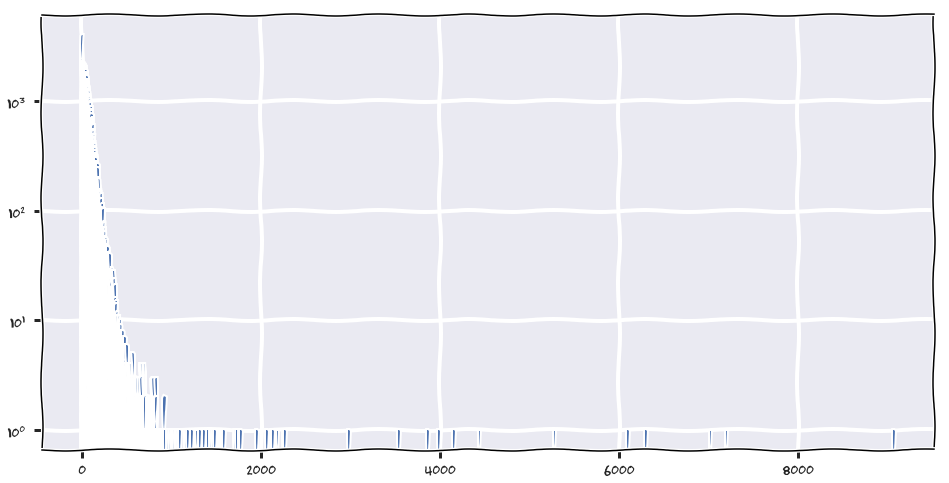

In [57]:
# one weird user with 2601351.02 days watches ruins the plot, ommiting him by xlim
users['user_days_spent_watching'].hist(bins=5000, figsize=(16, 8))
plt.gca().set_yscale('log')


In [58]:
users['user_days_spent_watching'].max()

9070.35

In [59]:
users[users['user_days_spent_watching'] == 2601351.02]

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes


In [60]:
one_user_data = lists_with_mins[lists_with_mins['username'] == 'warrose']
(one_user_data['my_watched_episodes'] * one_user_data['duration_min']).sum() / (60 * 24) # because it is in days

0.0

In [61]:
grouped_lists = lists_with_mins.groupby('username')

def count_to_days(group):
    return (group['my_watched_episodes'] * group['duration_min']).sum() / (60 * 24)

In [62]:
%%timeit
#(grouped_lists.get_group('warrose')['my_watched_episodes'] * grouped_lists.get_group('warrose')['duration_min']).sum() / (60 * 24)
# 2.88 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
count_to_days(grouped_lists.get_group('abystoma2'))
# 1.63 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

3.69 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
# now finally fixing days watch times
users['user_days_spent_watching'] = users['username'].apply(lambda x: count_to_days(grouped_lists.get_group(x)))


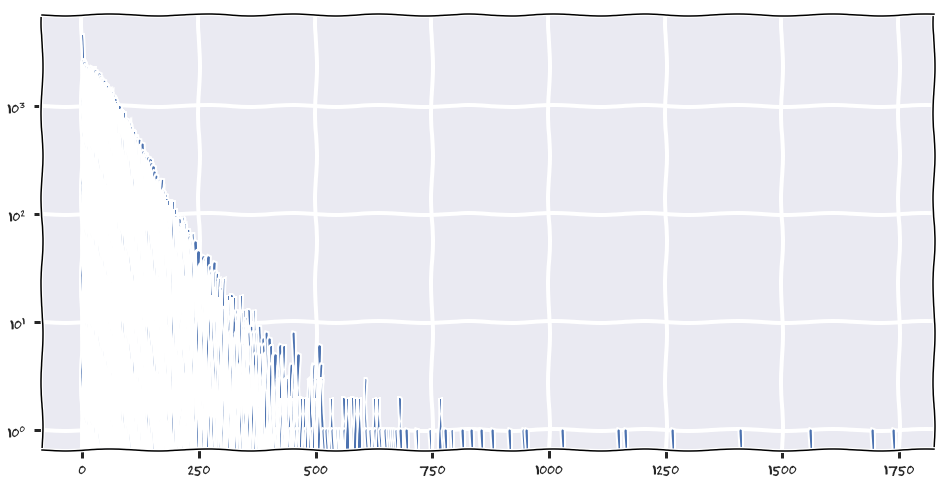

In [64]:
users['user_days_spent_watching'].hist(bins=1000, figsize=(16, 8))
plt.gca().set_yscale('log')


In [65]:
users.columns

Index(['username', 'user_id', 'user_watching', 'user_completed', 'user_onhold',
       'user_dropped', 'user_plantowatch', 'user_days_spent_watching',
       'gender', 'location', 'birth_date', 'access_rank', 'join_date',
       'last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes'],
      dtype='object')

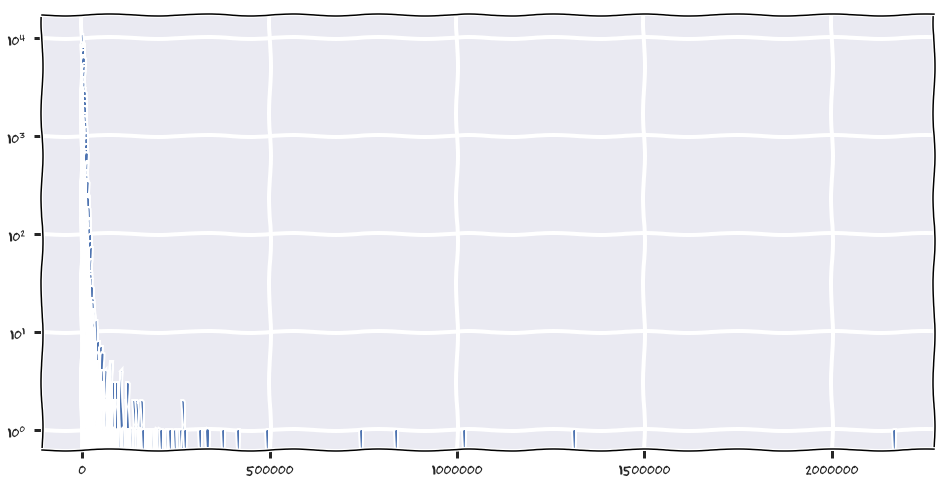

In [66]:
# so we need also to check number of watched episodes and fix them
users['stats_episodes'].hist(bins=5000, figsize=(16, 8))
plt.gca().set_yscale('log')


In [67]:
# actually fixing number of episodes
users['stats_episodes'] = users['username'].apply(lambda x: grouped_lists.get_group(x)['my_watched_episodes'].sum())


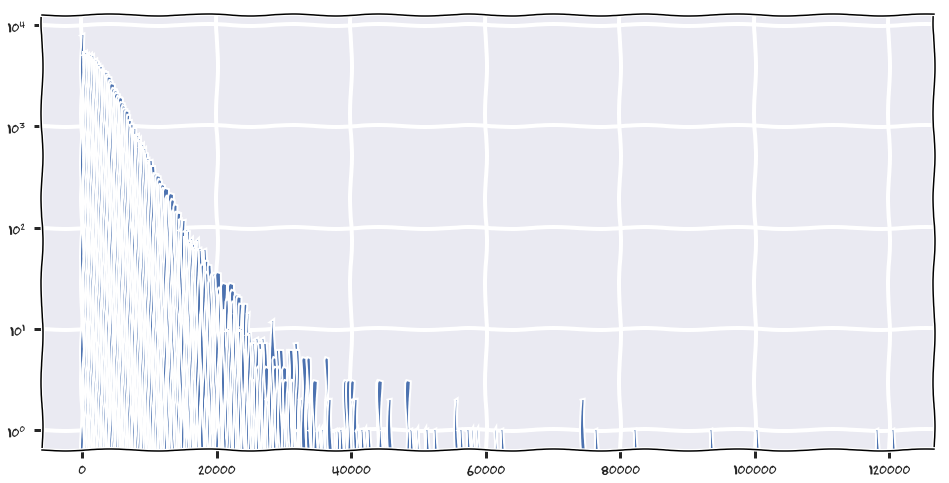

In [68]:
users['stats_episodes'].hist(bins=500, figsize=(16, 8))
plt.gca().set_yscale('log')


In [69]:
users.loc[users['stats_episodes'].nlargest(10).index][['username', 'stats_episodes']]

,username,stats_episodes
47808,ComfyLoli,120652
101868,Tsutaee,118093
41507,TsukasaKei,100333
30447,spacecowboy,93622
20966,Dedzapadlo,82260
74907,De_Baer,76422
62254,VincentHarkonnen,74422
74013,xbhrjd,74347
8728,dumnorix98,62347
17366,Loomir,61370


In [70]:
users[users['stats_episodes'] == 133457]

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes


In [71]:
#animelists_with_eps[animelists['username'] == 'dheiin_society']['my_watched_episodes'].nlargest(10)
animelists_with_eps[animelists['username'] == 'ComfyLoli'].sort_values(by='my_watched_episodes')

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,episodes,title
35788089,ComfyLoli,37481,0,0000-00-00,0000-00-00,0,6,0.0,0,2018-05-05 12:17:40,NaN,0,Ongaku Shoujo (TV)
34901467,ComfyLoli,28613,0,0000-00-00,0000-00-00,0,6,0.0,0,2014-12-17 16:44:26,NaN,0,Ginga Jinpuu Jinraiger
34900614,ComfyLoli,27785,0,0000-00-00,0000-00-00,0,6,NaN,0,2014-10-12 14:18:03,NaN,13,Doamaiger D
34899707,ComfyLoli,22465,0,0000-00-00,0000-00-00,0,6,0.0,0,2014-11-30 16:01:23,NaN,48,KutsuDaru.
34898326,ComfyLoli,21851,0,0000-00-00,0000-00-00,0,6,NaN,0,2015-04-29 13:56:37,NaN,12,Tesagure! Bukatsumono Encore
20035966,ComfyLoli,18295,0,0000-00-00,0000-00-00,0,6,NaN,0,2014-08-25 11:47:34,NaN,12,Kakumeiki Valvrave 2nd Season
20129823,ComfyLoli,21339,0,0000-00-00,0000-00-00,0,6,0.0,0,2014-12-04 16:25:06,NaN,1,Psycho-Pass Movie
34849507,ComfyLoli,21671,0,0000-00-00,0000-00-00,0,1,NaN,0,2014-08-31 14:14:31,NaN,23,Keroro
20335297,ComfyLoli,23777,0,0000-00-00,0000-00-00,0,6,0.0,0,2014-11-30 16:13:04,NaN,1,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa
19934345,ComfyLoli,15377,0,0000-00-00,0000-00-00,0,6,NaN,0,2014-10-27 21:16:26,NaN,12,Hyakka Ryouran: Samurai Bride


In [72]:
animelists.describe()

,anime_id,my_watched_episodes,my_score,my_status,my_rewatching,my_rewatching_ep
count,3.579398e+07,3.579398e+07,3.579398e+07,3.579398e+07,2.802716e+07,3.579398e+07
mean,1.169565e+04,1.213340e+01,4.538777e+00,3.038835e+00,7.663282e-04,1.605091e-01
std,1.137970e+04,3.612339e+01,3.915338e+00,1.746322e+00,2.767203e-02,9.434558e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.690000e+03,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,7.870000e+03,3.000000e+00,6.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
75%,1.967100e+04,1.300000e+01,8.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
max,3.791600e+04,9.999000e+03,1.000000e+01,5.500000e+01,1.000000e+00,5.644513e+06


In [73]:
animelists.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,2012-12-14 10:25:01,NaN
2,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,2009-09-30 07:39:05,NaN
3,bskai,21,75,0000-00-00,0000-00-00,8,1,0.0,0,2010-06-15 21:31:23,NaN
4,Slimak,21,834,0000-00-00,0000-00-00,10,1,0.0,0,2018-05-01 12:05:21,NaN


## Now I have some basic filtering done and data is fixed, inspecting birth date and age

In [74]:
users['age'] = 2018 - users['birth_date'].dt.year

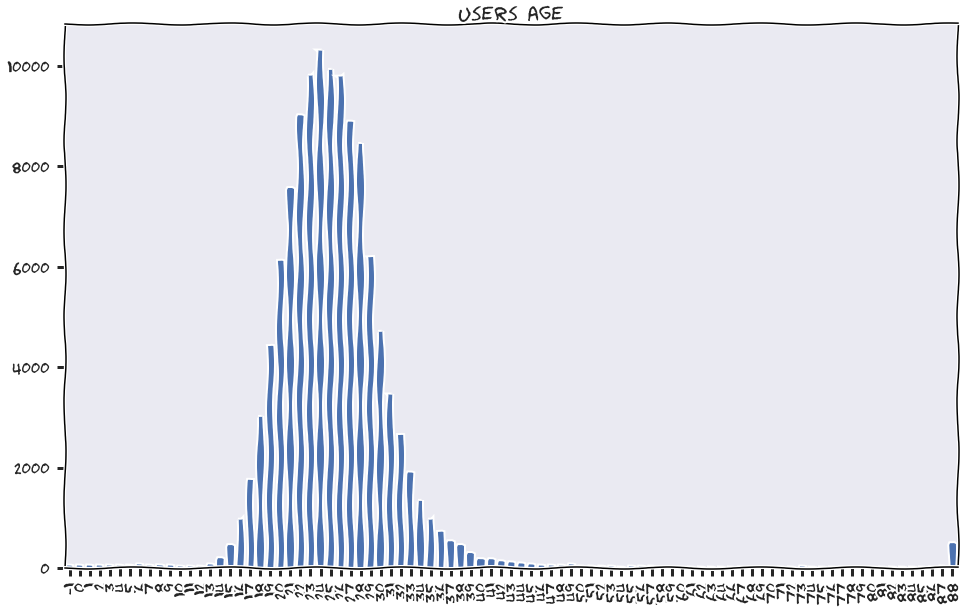

In [93]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users age')

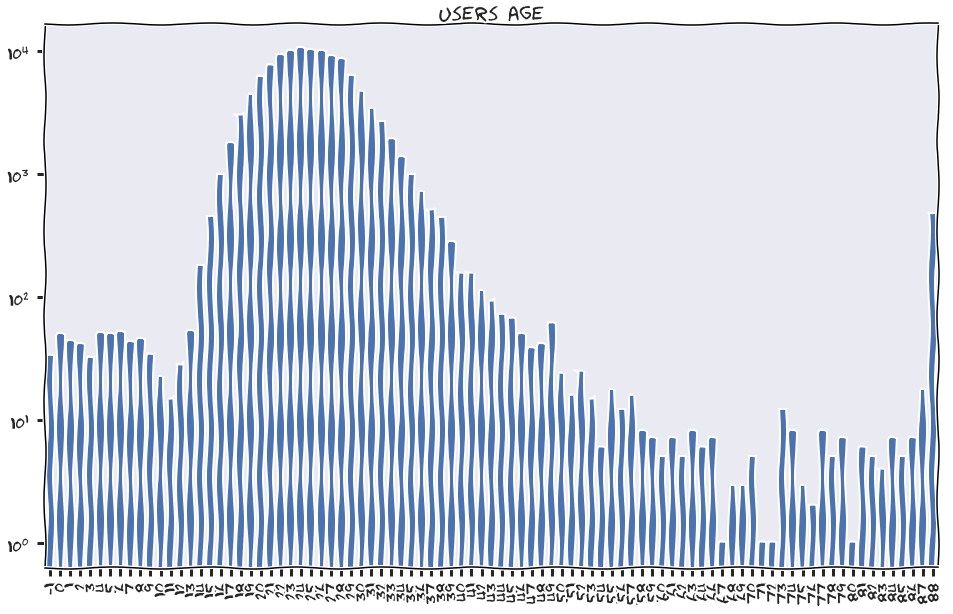

In [94]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='users age', logy=True)

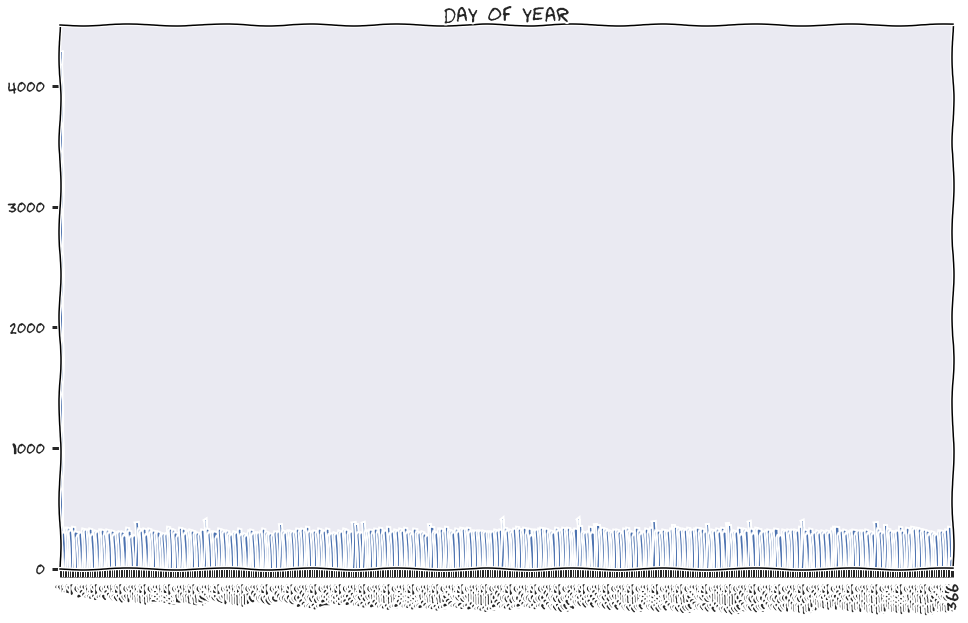

In [95]:
users['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), title='day of year')

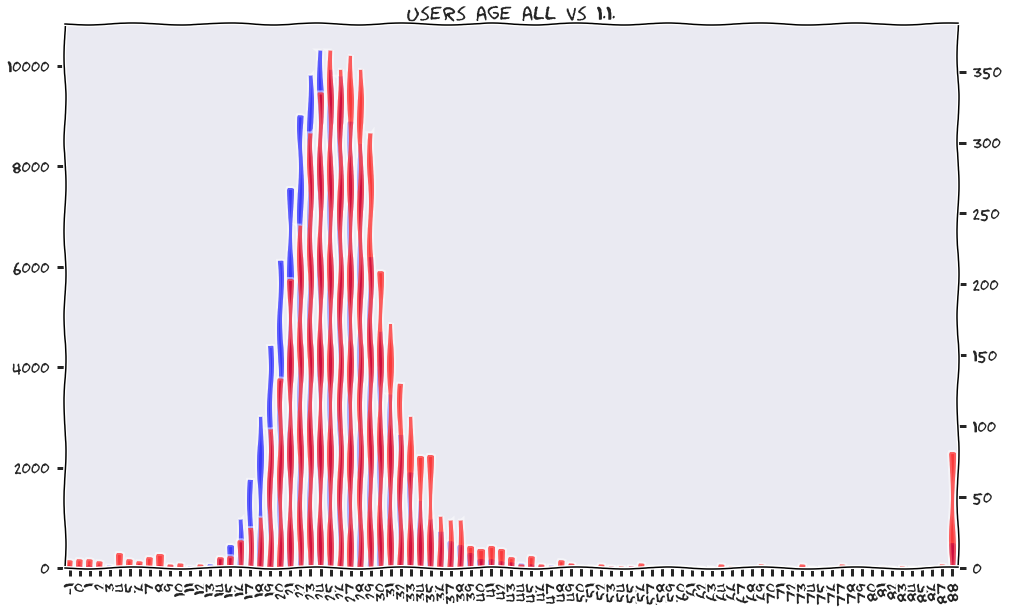

In [96]:
# this shows how people born in 1.1. are biased and thus can not be trusted
total_count = users['age'].count()
first_jan_count = users[users['birth_date'].dt.dayofyear == 1]['age'].count()
plt.figure(figsize=(16, 10))
ax = plt.gca()

users_in_first_jan = users[users['birth_date'].dt.dayofyear == 1]['age'].value_counts()
users_in_first_jan = users_in_first_jan.reindex(users['age'].value_counts().index)
users['age'].value_counts().sort_index().plot.bar(ax=ax, title='users age all vs 1.1.', color='blue', alpha=0.5)
users_in_first_jan.sort_index().plot.bar(ax=ax, color='red', alpha=0.5, secondary_y=True)
#ax.set_xlim(users['age'].min(), users['age'].max())
#plt.xticks(users['age'].value_counts().index)
plt.show()

In [97]:
import zodiac_sign
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime

In [98]:
users['zodiac_sign'] = users['birth_date'].apply(zodiac_sign.get_zodiac_sign)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

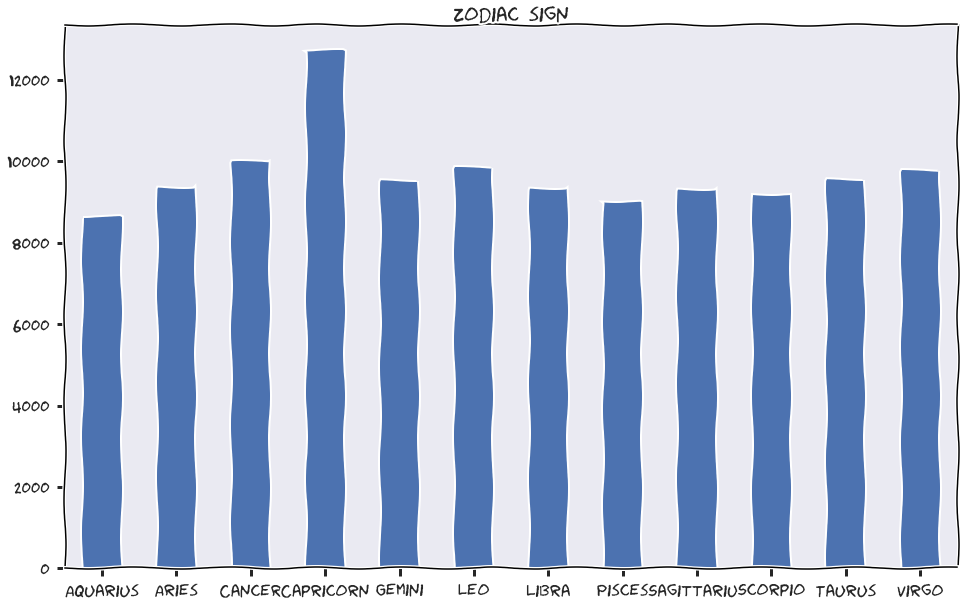

In [99]:
users['zodiac_sign'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='Zodiac sign')
plt.xticks(rotation=0)

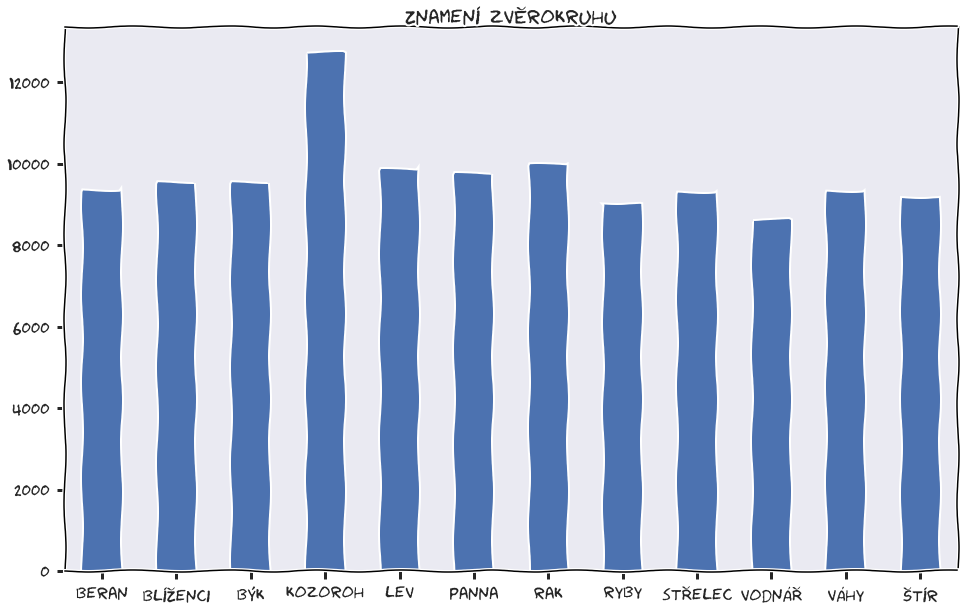

In [100]:
# česky:
en_cz_zodiac = {
    "Aries": "beran",
    "Taurus": "býk",
    "Gemini": "blíženci",
    "Cancer": "rak",
    "Leo": "lev",
    "Virgo": "panna",
    "Libra": "váhy",
    "Scorpio": "štír",
    "Sagittarius": "střelec",
    "Capricorn": "kozoroh",
    "Aquarius": "vodnář",
    "Pisces": "ryby",
}

users['zodiac_sign'].apply(lambda x: en_cz_zodiac[x]).value_counts().sort_index().plot.bar(figsize=(16, 10), title='Znamení zvěrokruhu')
plt.xticks(rotation=0)
plt.savefig('graphs/znameni-zverokruhu.png', bbox_inches="tight")

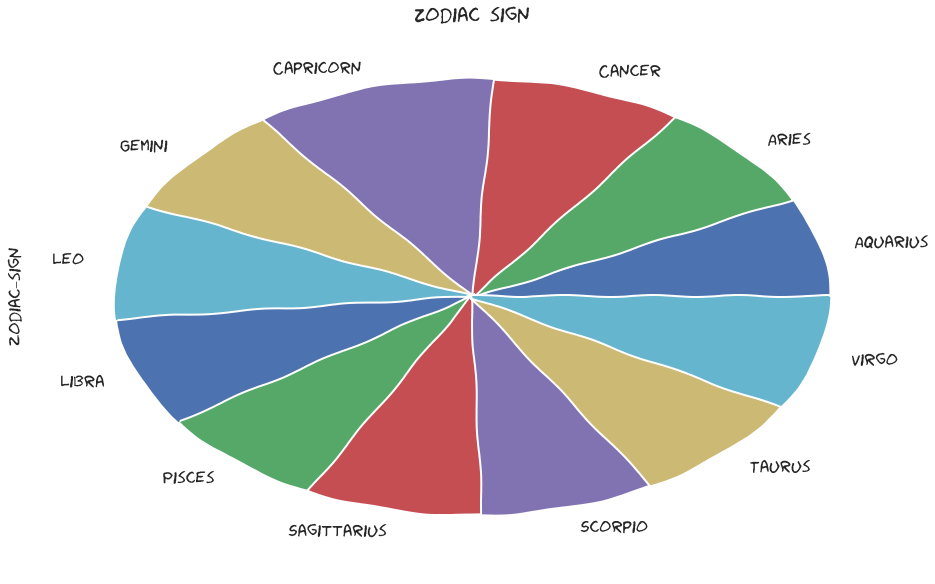

In [101]:
users['zodiac_sign'].value_counts().sort_index().plot.pie(figsize=(16, 10), title='Zodiac sign') 

In [102]:
capricorn_idx = [(index, name) for index, name in zodiac_sign.en_dict if name == 'Capricorn'][0][0]
capri_r = zodiac_sign.sign_dates[capricorn_idx]
capri_r

((22, 12), (19, 1))

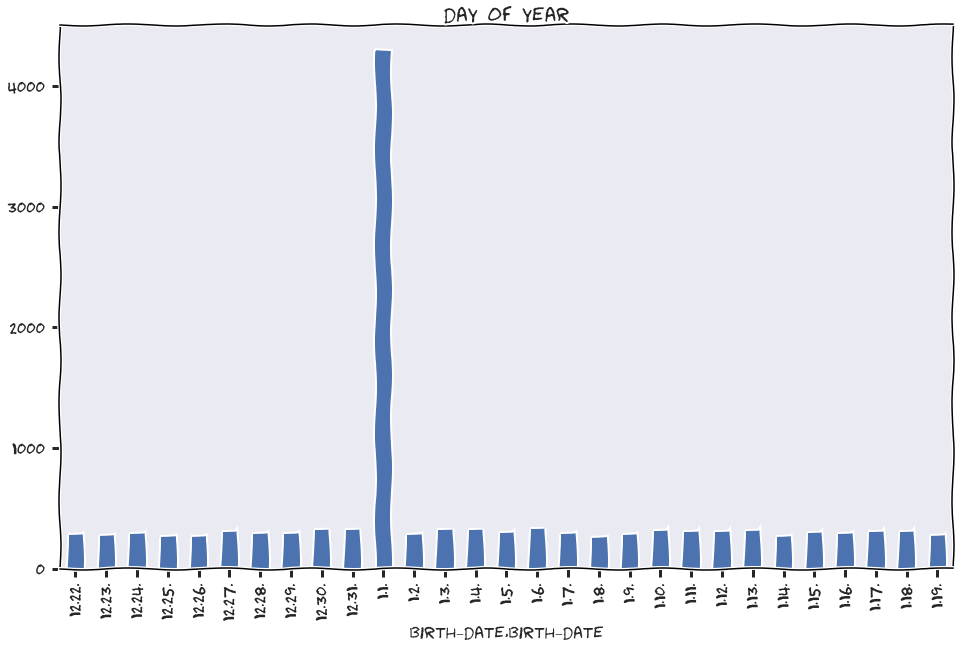

In [103]:
capri_range_condition = ((users['birth_date'].dt.day >= capri_r[0][0]) & (users['birth_date'].dt.month >= capri_r[0][1])) | ((users['birth_date'].dt.day <=capri_r[1][0]) & (users['birth_date'].dt.month <=capri_r[1][1]))
plt.figure(figsize=(16, 10))
#capri_days = users[capri_range_condition]['birth_date'].dt.dayofyear.value_counts()
capri_days = users[capri_range_condition].groupby([(users['birth_date'].dt.month),(users['birth_date'].dt.day)]).agg('count') ['birth_date']
capri_days_2 = capri_days.rename(index={12: 0}, level=0).sort_index()
capri_days_2.plot.bar(ax=plt.gca(), title='day of year')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '{}.{}.'.format(capri_days_2.index[x][0] if capri_days_2.index[x][0] == 1 else 12, capri_days_2.index[x][1])))
plt.show()

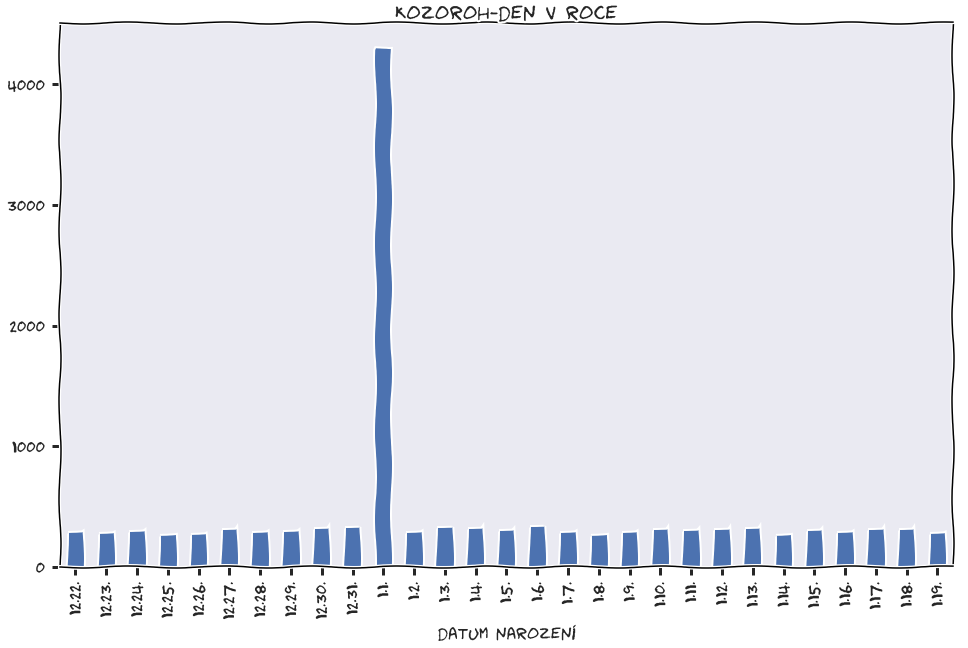

In [104]:
plt.figure(figsize=(16, 10))
capri_days_2.plot.bar(ax=plt.gca(), title='Kozoroh-den v roce')
plt.gca().get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: '{}.{}.'.format(capri_days_2.index[x][0] if capri_days_2.index[x][0] == 1 else 12, capri_days_2.index[x][1])))
plt.xlabel('datum narození')
plt.savefig('graphs/zverokruh-dny', bbox_inches="tight")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

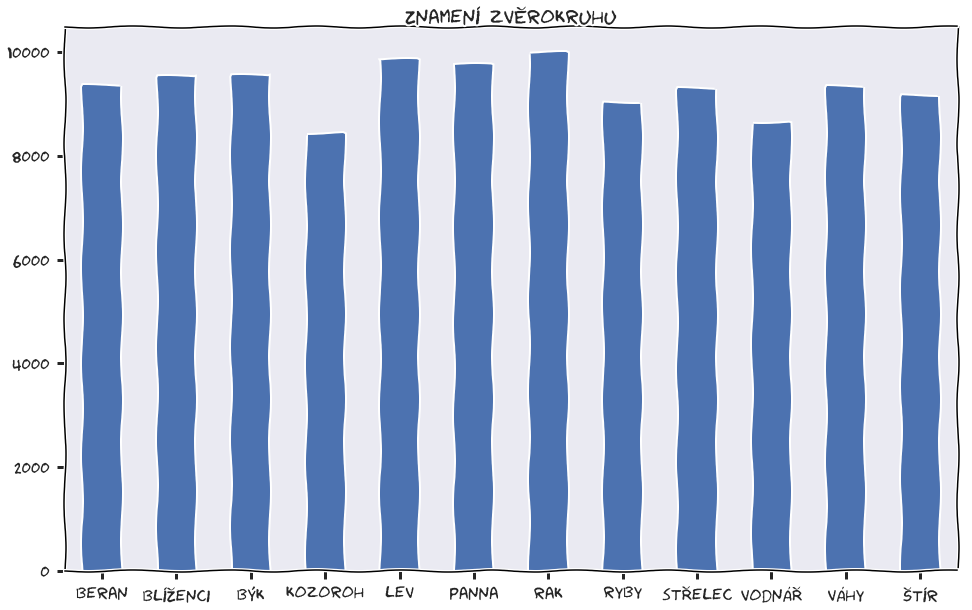

In [105]:
# nyní bez 1.1.
users[users['birth_date'].dt.dayofyear != 1]['zodiac_sign'].apply(lambda x: en_cz_zodiac[x]).value_counts().sort_index().plot.bar(figsize=(16, 10), title='Znamení zvěrokruhu')
plt.xticks(rotation=0)

## now I'll be filtering out all people with too litle watch time

In [230]:
print('users with less than hour watching: ', (users['user_days_spent_watching'] <= 1/2).sum())  # 4 hours

users with less than hour watching:  2105


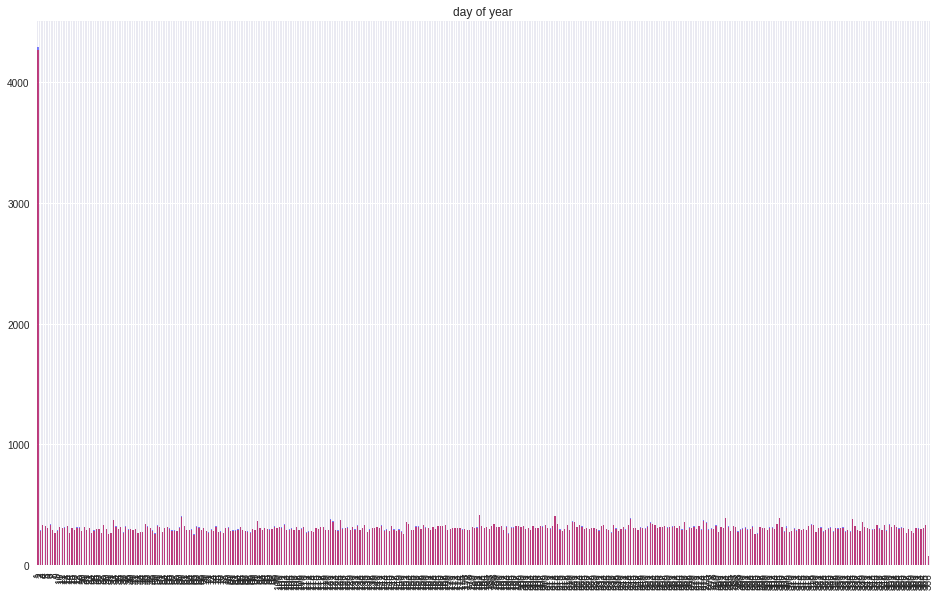

In [231]:
users['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), title='day of year', color='blue', alpha=0.5)
users[users['user_days_spent_watching'] > 1/6]['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5)


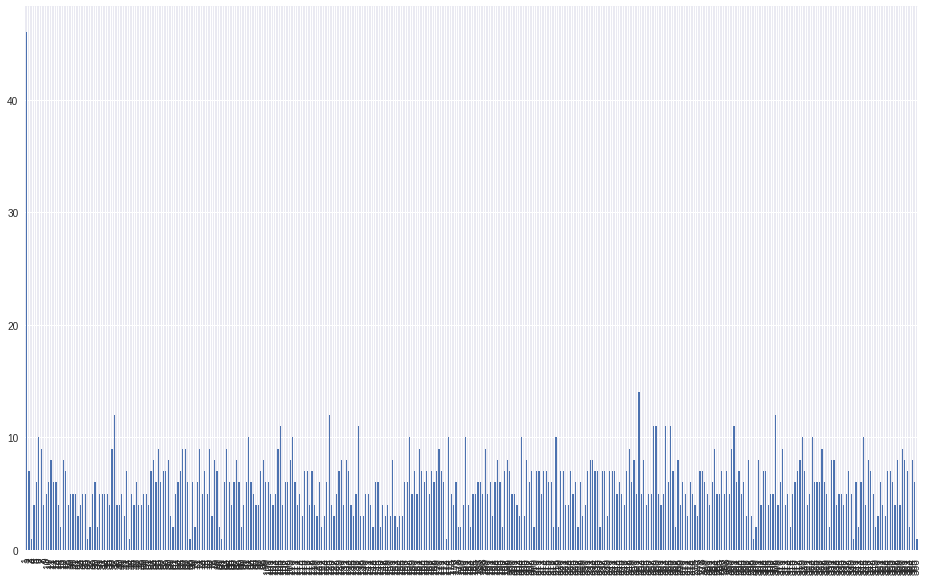

In [232]:
users[users['user_days_spent_watching'] <= 1/2]['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10))

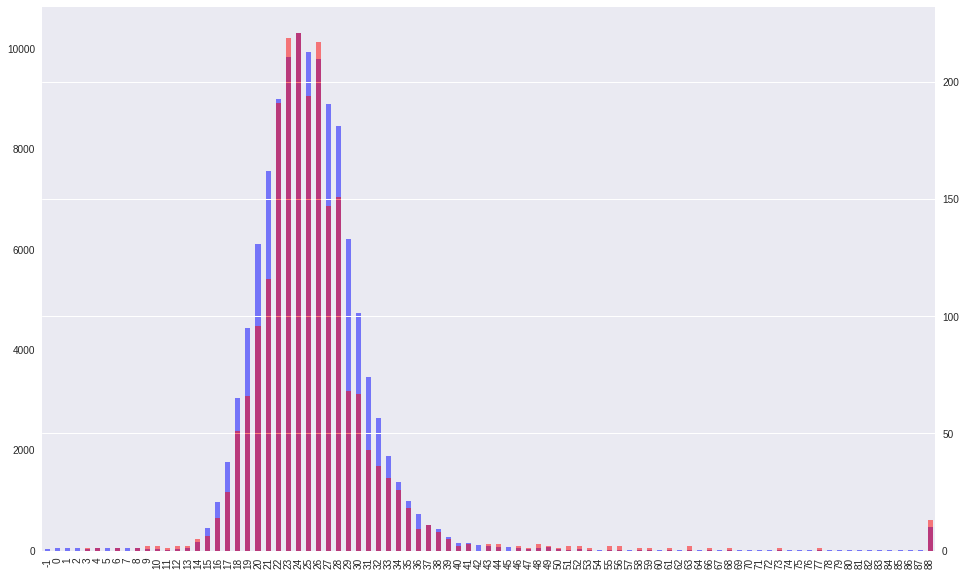

In [233]:
users_too_few_watch = users[users['user_days_spent_watching'] <= 1/2]['age'].value_counts()
users_too_few_watch = users_too_few_watch.reindex(users['age'].value_counts().index)
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10), color='blue', alpha=0.5)
users_too_few_watch.sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, secondary_y=True)

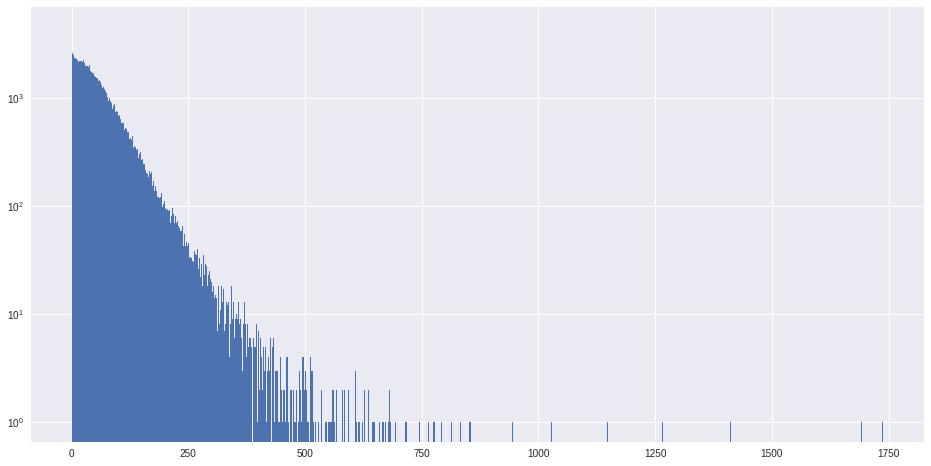

In [234]:
users['user_days_spent_watching'].hist(bins=1000, figsize=(16, 8))
plt.gca().set_yscale('log')

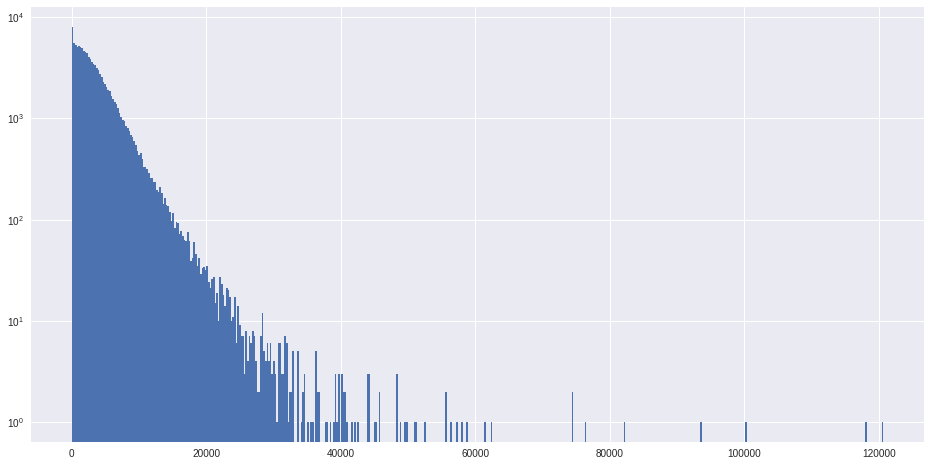

In [235]:
users['stats_episodes'].hist(bins=500, figsize=(16, 8))
plt.gca().set_yscale('log')

In [236]:
# filtering
users = users[users['user_days_spent_watching'] > 1/2]

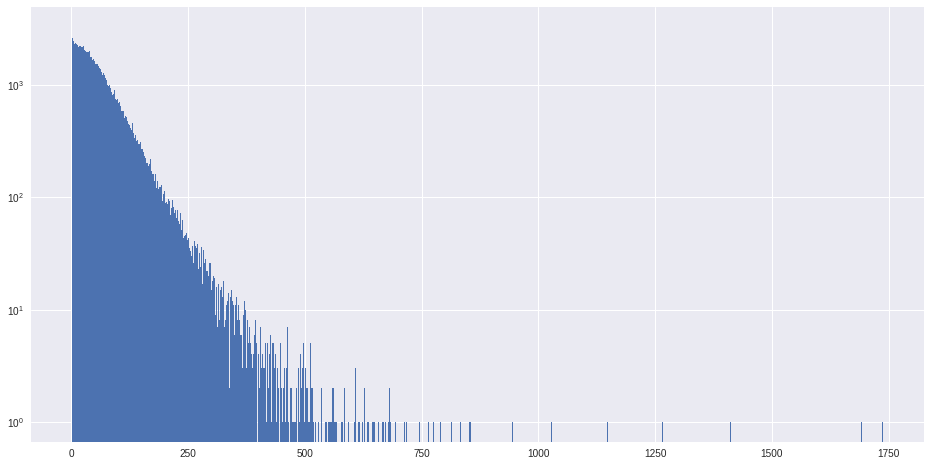

In [237]:
users['user_days_spent_watching'].hist(bins=1000, figsize=(16, 8))
plt.gca().set_yscale('log')

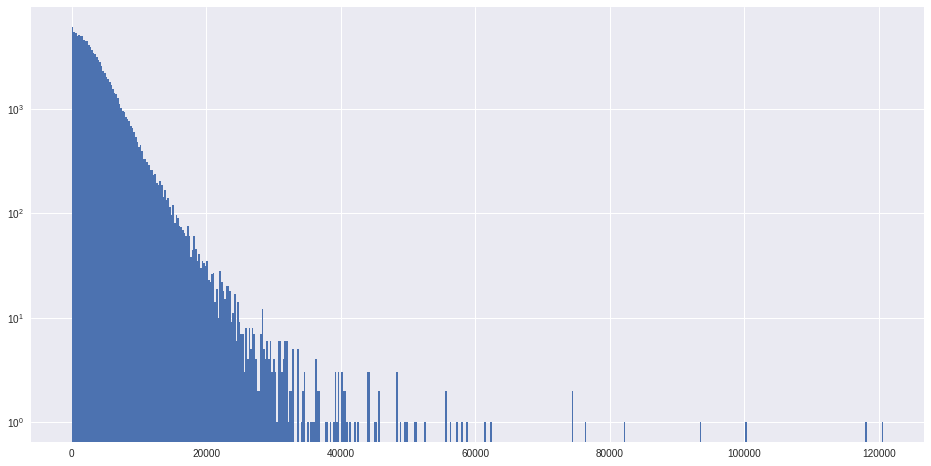

In [238]:
users['stats_episodes'].hist(bins=500, figsize=(16, 8))
plt.gca().set_yscale('log')

## filtering by age

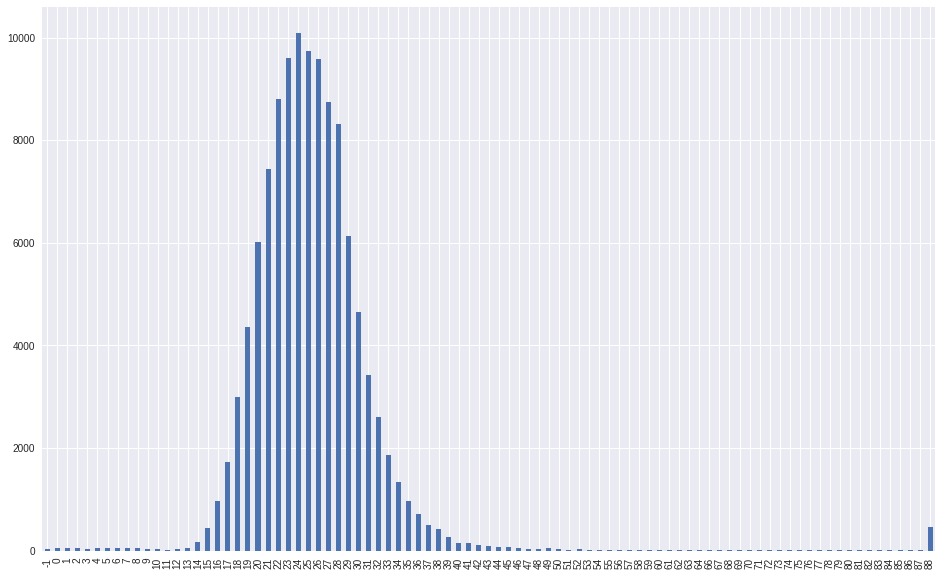

In [239]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10))

In [240]:
users = users[(users['age'] > 9) & (users['age'] < 50)]

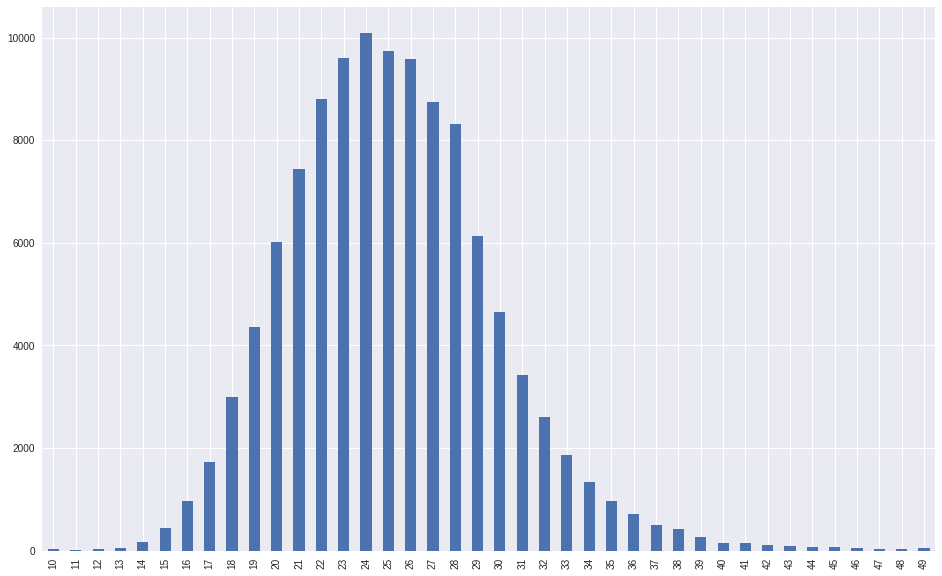

In [241]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10))

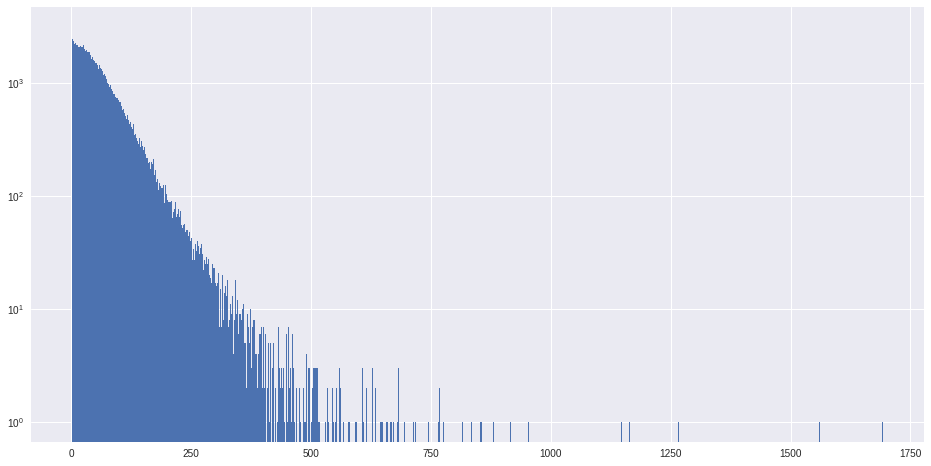

In [242]:
users['user_days_spent_watching'].hist(bins=1000, figsize=(16, 8))
plt.gca().set_yscale('log')

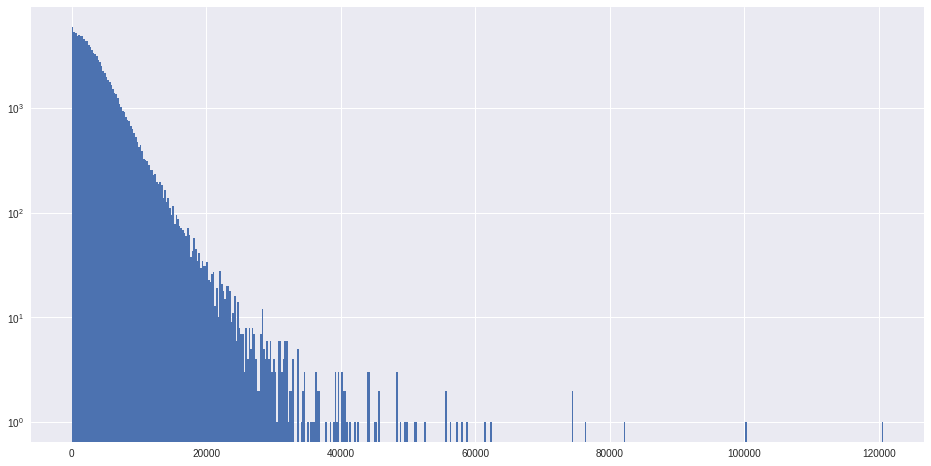

In [243]:
users['stats_episodes'].hist(bins=500, figsize=(16, 8))
plt.gca().set_yscale('log')

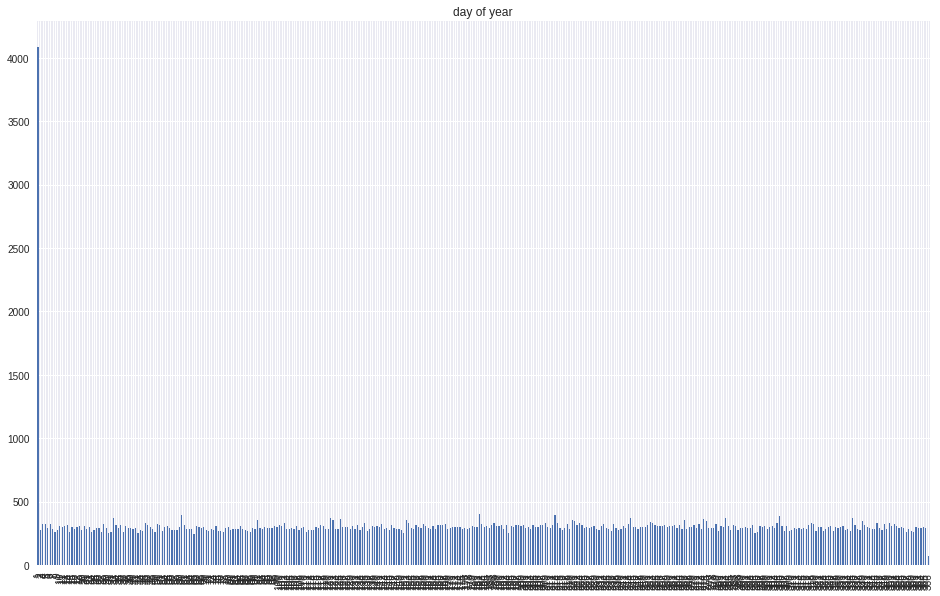

In [244]:
users['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), title='day of year')

In [245]:
# filtering users born in 1.1., too many false people here
users = users[users['birth_date'].dt.dayofyear != 1]

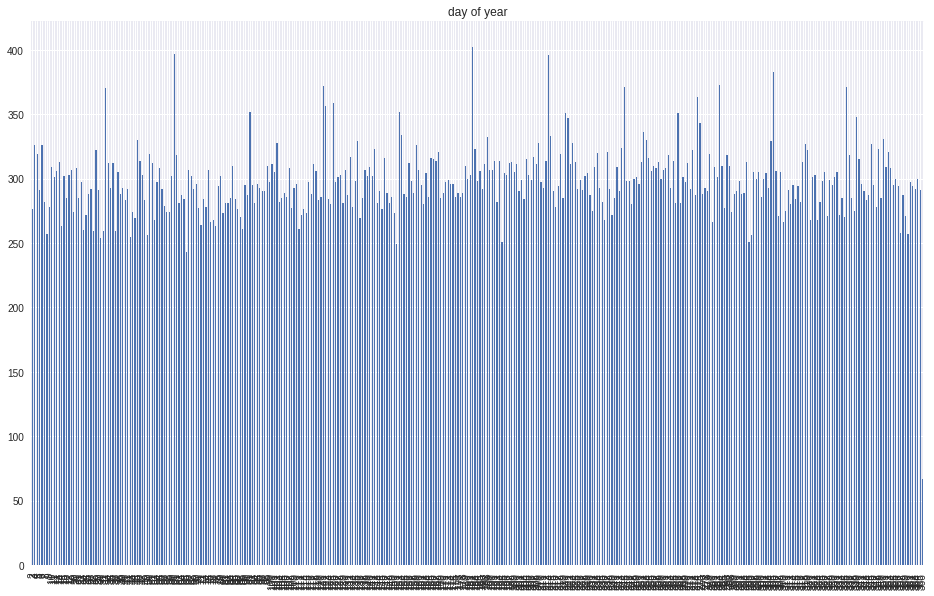

In [246]:
users['birth_date'].dt.dayofyear.value_counts().sort_index().plot.bar(figsize=(16, 10), title='day of year')

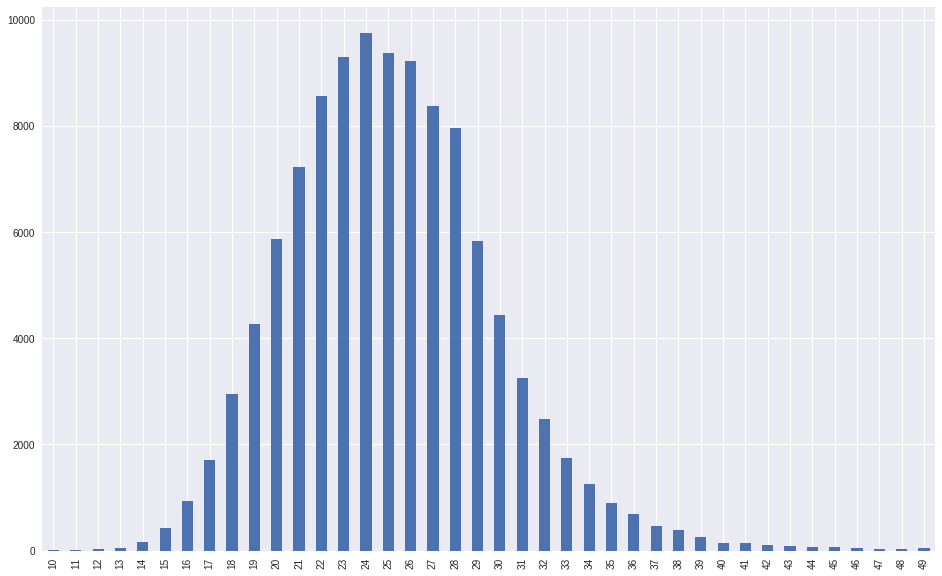

In [247]:
users['age'].value_counts().sort_index().plot.bar(figsize=(16, 10))

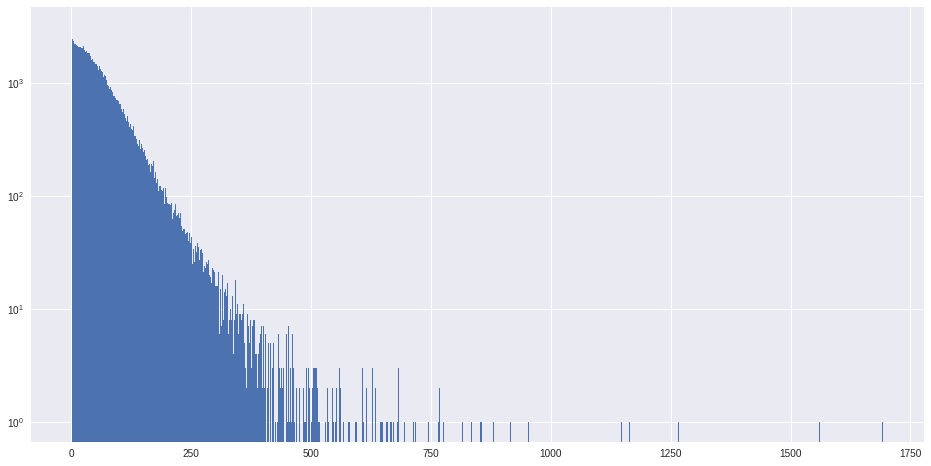

In [248]:
users['user_days_spent_watching'].hist(bins=1000, figsize=(16, 8))
plt.gca().set_yscale('log')

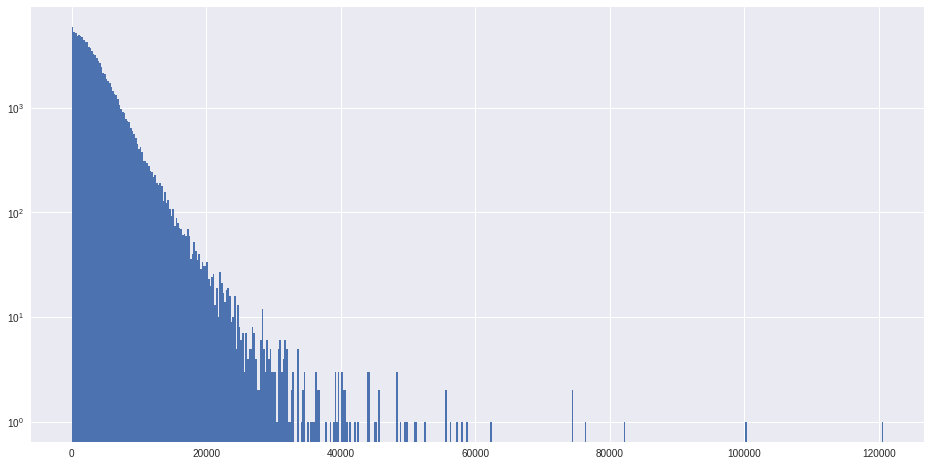

In [249]:
users['stats_episodes'].hist(bins=500, figsize=(16, 8))
plt.gca().set_yscale('log')

In [250]:
users.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,age,zodiac_sign
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391,28,Taurus
2,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,2017-07-10 06:52:54,6.15,6.0,4903,27,Leo
3,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,9701,28,Sagittarius
4,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,697,20,Virgo
5,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,2018-05-10 20:53:37,7.86,0.0,1847,19,Scorpio


In [251]:
users = users.drop(['zodiac_sign'], axis=1)
users = users.drop(['age'], axis=1)  # everyone can easily calculate this column, so there is no need to keep it

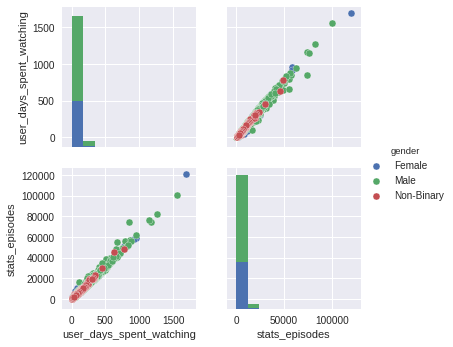

In [252]:
# showing scatterplot before and after dropping few users with very large animelists
sns.pairplot(users[['user_days_spent_watching',
       'gender', 'birth_date', 'join_date',
       'last_online', 'stats_episodes']], hue='gender')

In [253]:
print('going to delete {} users with 70k episodes or more, there is too few of them and they mess with graphs'.format((users['stats_episodes'] >= 70000).sum()))
users_small = users[users['stats_episodes'] < 70000]

going to delete 6 users with 70k episodes or more, there is too few of them and they mess with graphs


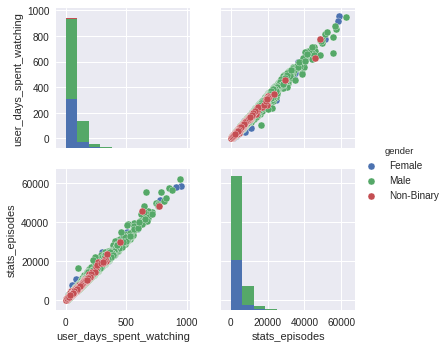

In [254]:
# showing scatterplot after and after dropping few users with very large animelists
sns.pairplot(users_small[['user_days_spent_watching',
       'gender', 'birth_date', 'join_date',
       'last_online', 'stats_episodes']], hue='gender')

In [255]:
users = users_small

In [256]:
users.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391
2,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,2017-07-10 06:52:54,6.15,6.0,4903
3,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,9701
4,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,697
5,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,2018-05-10 20:53:37,7.86,0.0,1847


In [257]:
users.describe()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,access_rank,stats_mean_score,stats_rewatched,stats_episodes
count,1.087110e+05,108711.000000,108711.000000,108711.000000,108711.000000,108711.000000,108711.000000,0.0,108711.000000,108711.000000,108711.000000
mean,1.817687e+06,14.767503,196.458178,11.388167,11.733716,75.578589,61.913873,NaN,7.747612,14.197993,3779.871255
std,1.998269e+06,32.746591,244.945751,30.830825,30.978991,178.653664,59.211762,NaN,1.451368,55.376799,3678.336729
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.500694,NaN,0.000000,0.000000,7.000000
25%,1.994345e+05,3.000000,50.000000,0.000000,0.000000,6.000000,21.066319,NaN,7.330000,0.000000,1269.500000
50%,5.675030e+05,7.000000,123.000000,4.000000,3.000000,27.000000,46.190278,NaN,7.890000,1.000000,2797.000000
75%,3.477036e+06,16.000000,254.000000,12.000000,12.000000,81.000000,84.461806,NaN,8.460000,10.000000,5135.000000
max,7.251737e+06,2934.000000,5479.000000,2562.000000,2457.000000,12051.000000,952.654595,NaN,10.000000,9404.000000,62347.000000


In [258]:
# clearing animelists according to dropped users
animelists_smaller = pd.merge(animelists, users, on='username', how='right')
animelists_smaller.describe()

KeyboardInterrupt: 

In [ ]:
animelists.describe()

In [ ]:
animelists.head()

In [ ]:
print('unique anime before filtering: ', animelists['anime_id'].unique().shape)
print('unique anime after filtering: ', animelists_smaller['anime_id'].unique().shape)

In [ ]:
# now replacing data with cleaned animelists, using only columns before merge
animelists = animelists_smaller[animelists.columns]

In [ ]:
animes = animes[animes['anime_id'].isin(animelists_smaller['anime_id'].unique())]

In [ ]:
animes.describe()

### Filtering anime with lots of missing info

In [ ]:
animes['source'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime sources')

In [ ]:
# now dropping anime with unknown studio and unkown source
delete_filter = (animes['source'] == 'Unknown')
animes_to_delete = animes[delete_filter]
animes_to_remain = animes[~(delete_filter)]
anime_ids_to_delete = animes_to_delete['anime_id']
print('anime to delete: ', animes_to_delete.shape)

In [ ]:
# now with unkown source
delete_filter = (animes['source'] == 'Unknown') | (animes['studio'].isnull())
animes_to_delete = animes[delete_filter]
animes_to_remain = animes[~(delete_filter)]
anime_ids_to_delete = animes_to_delete['anime_id']
print('anime to delete: ', animes_to_delete.shape)

In [ ]:
# now not aired anime, because I don't care about them
delete_filter = delete_filter | ((animes['status'] == 'Not yet aired'))
animes_to_delete = animes[delete_filter]
animes_to_remain = animes[~(delete_filter)]
anime_ids_to_delete = animes_to_delete['anime_id']
print('anime to delete: ', animes_to_delete.shape)

In [ ]:
# I need year of airing start, so I will be filtering all anime without that
animes['aired_from_year'] = pd.to_datetime(animes['aired'].apply(lambda x: ast.literal_eval(x.replace('\'', '"'))['from']), errors='coerce').dt.year
print('animes without aired json info', animes[~(delete_filter) & animes['aired_from_year'].isnull()].shape)

In [ ]:
animes[~(delete_filter) & animes['aired_from_year'].isnull()][['anime_id', 'title', 'type', 'source', 'status', 'genre', 'aired_string', 'aired', 'aired_from_year', 'popularity', 'rating', 'rank']]

In [ ]:
# now, for anime with airing year in aired_string column, I use that year to fill aired_from_year
years_from_string = animes['aired_string'].str.extract(r'(\d{4})')
animes.loc[animes['aired_from_year'].isnull(), 'aired_from_year'] = years_from_string[animes['aired_from_year'].isnull()]
# after that, I have finally airing year of all anime which were not filtered out

In [ ]:
delete_filter = delete_filter | ((animes['aired_string'] == 'Not available'))
animes_to_delete = animes[delete_filter]
animes_to_remain = animes[~(delete_filter)]
anime_ids_to_delete = animes_to_delete['anime_id']
print('anime to delete: ', animes_to_delete.shape)

In [ ]:
animes[~(delete_filter) & animes['aired_from_year'].isnull()][['anime_id', 'title', 'type', 'source', 'status', 'genre', 'aired_string', 'aired', 'aired_from_year', 'popularity', 'rating', 'rank']]

In [ ]:
animes.columns

In [ ]:
animes.loc[76]

In [ ]:
animes['aired_string'].value_counts()

In [ ]:
animes_to_remain['rating'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime ranks', color='blue', alpha=0.5)
animes_to_delete['rating'].value_counts().sort_index().plot.bar(figsize=(16, 10), title='anime ranks', color='red', alpha=0.5, secondary_y=True)


In [ ]:
animes_to_remain['genre'].fillna('', inplace=True)
animes_genres_to_remain = animes_to_remain['genre'].apply(lambda x: x.replace(' ', ''))
genres_to_remain = animes_to_remain['genre'].apply(lambda x: x.replace(' ', '').split(','))
genres_to_remain = pd.Series([y for x in genres_to_remain for y in x if y != '']).value_counts()
genres_occurence_to_remain = pd.Series({genre: (animes_genres_to_remain.str.contains(genre)).sum() for genre in genres_to_remain.index})
genres_occurence_to_remain.plot(kind='bar', figsize=(16, 10), color='blue', alpha=0.5)

animes_to_delete['genre'].fillna('', inplace=True)
animes_genres_to_delete = animes_to_delete['genre'].apply(lambda x: x.replace(' ', ''))
genres_to_delete = animes_to_delete['genre'].apply(lambda x: x.replace(' ', '').split(','))
genres_to_delete = pd.Series([y for x in genres_to_delete for y in x if y != '']).value_counts()
genres_occurence_to_delete = pd.Series({genre: (animes_genres_to_delete.str.contains(genre)).sum() for genre in genres_to_delete.index})
genres_occurence_to_delete.plot(kind='bar', figsize=(16, 10), color='red', alpha=0.5, secondary_y=True)


In [ ]:
animes = animes_to_remain

In [ ]:
animelists[animelists['anime_id'].isin(anime_ids_to_delete)].shape

In [ ]:
animelists = animelists[~animelists['anime_id'].isin(anime_ids_to_delete)]

In [ ]:
animelists.shape

In [ ]:
animelists.describe()

In [ ]:
animes.describe()

In [ ]:
animelists['username'].unique().shape
# no users rated only these truncated anime, so no need to clear users now

In [138]:
animes[animes['aired_from_year'].isnull()][['aired_string', 'aired_from_year']]

,aired_string,aired_from_year


In [139]:
animes.to_csv('anime_cleaned.csv', index=False, sep=',', encoding='utf-8')
users.to_csv('users_cleaned.csv', index=False, sep=',', encoding='utf-8')
animelists.to_csv('animelists_cleaned.csv', index=False, sep=',', encoding='utf-8')